# Lab 3: GNN Scalibility and Explanability

In this lab, you will learn how to implement scalable GNN methods and GNN explainers. Specially, you will

*   Implement different graph-based scalibility and explanability techniques
*   Analyze the performances of different scalable GNNs
*   Explain the performance of explainers

**Completion requirements**

By the end of this notebook, you should have:

*  Implement all the code cells for the scalable GNNs and GNN explainer
*  training the methods
*  assesing the performance of the methods.
 



---

## Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:

- TDC
- Numpy
- Pytorch
- NetworkX
- Matplotlib
- Scikit-learn
- Pytorch geometric  

Run the following code to import the packages

In [1]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [81]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import copy
import os.path as osp

import torch
from torch.nn import ModuleList
import torch.nn.functional as F
from torch_geometric.nn import APPNP
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, ClusterGCNConv

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborSampler, NeighborLoader

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# import the datasets
from torch_geometric.datasets import Planetoid

## Dataset

In this lab, we will work with a benchmark dataset called **Cora**. This dataset contains 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links, indicating the citation relationship among the publications. We will treat publications as nodes and their relationship as edges in the graph.

Run the following code to load the cora dataset:

In [82]:
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]
data.x.shape

torch.Size([2708, 1433])

## Problem Definition 

In the following two sections Lab3.1 and Lab3.2, you will perform the node classification task, where you are given a graph and its incomplete labeling, and the goal is to predict the classes of the unlabeled nodes. A tutorial to perform the node classification task on dataset Cora can be found under the link: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

___

## Lab 3.1: Scalable GNN Methods

In this section, you will implement and analyse the performances of scalable GNN methods GraphSage and ClusterGCN. The node classification task is conducted using Cora. We will employ mini-batch training in this section. Find the tutorial on mini-batch training using pytorch geometric here: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html, and https://machinelearningmastery.com/mini-batch-gradient-descent-and-dataloader-in-pytorch/

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

  **(a) Define and instantiate a GraphSAGE model with the following parameters:**
  
  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 128
  - num_layers: 2
  - out_channels: number of classes in Cora
  - sample size for training: [5, 2]
  - learning rate: 0.01
  - batch size: 1024
  - drop out rate: 0.5
  
  **train the model for 200 epochs and record the training loss and accuracy**
  
  **visualize the training loss and accuracy on the test set as a function to the epochs**

The creation of mini-batching is crucial for letting the training of a deep learning model scale to huge amounts of data. Here, we first build data loader for training and test. Call the Neighborloader in Pytorch Geometric to build the loaders with the sample size, batch size specified above in the following cell: 

In [136]:
# for mini-batch training
S_in_channels = data.num_features
S_hidden_channels = 128
S_num_layers = 2
S_out_channels = cora_dataset.num_classes

S_num_train = [10, 5]
S_num_test = [10, 5]

lr = 0.01
S_batch_size = 1024
S_dropout = 0.5

# build loaders to break the graph for train
S_train_loader = NeighborLoader(
    data,
    num_neighbors=S_num_train,
    batch_size=S_batch_size,
    input_nodes=data.train_mask,
)

# build loaders to break the graph for test
S_subgraph_loader = NeighborLoader(
    data,
    num_neighbors=S_num_test,
    batch_size=S_batch_size,
    input_nodes=data.test_mask,
)

In [137]:
single_batch = next(iter(S_subgraph_loader))
print(single_batch)

Data(x=[2481, 1433], edge_index=[2, 7479], y=[2481], train_mask=[2481], val_mask=[2481], test_mask=[2481], n_id=[2481], e_id=[7479], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[1000], batch_size=1000)


In pytorch geometric, the SAGEConv layer is implemented. Here we can use the predefined SAGEConv layer to build our GraphSAGE model. Define and instantiate the GraphSAGE model in the following cell:

In [138]:
#################################################################
#add your code here to define and instantiate the GraphSAGE model
device = "cpu"
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.layers.append(SAGEConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.layers.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.layers.append(SAGEConv(hidden_channels, out_channels))

    
    # define the forward function here
    # note that in batch training the loss has to be backpropagated for each batch, write the function accordingly
    def forward(self, x, edge_index):
        for i in range(len(self.layers) - 1):
            x  = self.layers[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=S_dropout, training=self.training)
        
        x = self.layers[-1](x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    # define the inference function here
    # Compute representations of nodes layer by layer
    # This leads to faster computation in contrast to immediately computing the final representations of each batch
    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
      for batch_size, n_id, adjs in subgraph_loader:
          adjs = [adj.to(device) for adj in adjs]
          x = x_all[n_id].to(device)
          edge_index = adjs[0][1].to(device)
          x = self(x, edge_index)
          x_all[n_id] = x.cpu()
      return x_all

graphSAGE = SAGE(S_in_channels, S_hidden_channels, S_out_channels, S_num_layers).to(device)

#################################################################

According to the instructions left in the following cell, define the training and test function of the previous defined GraphSAGE model:

In [139]:
#################################################################
# define a train function for the graphsage model
def S_train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    total_nodes = 0
    total_correct = 0
    # use the training loader for mini-batch training
    for data in train_loader:
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

        # backpropagate the loss in this batch
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        # sum the batch loss to the total loss       
        total_loss += loss.item() * data.num_nodes
        total_nodes += data.num_nodes
        total_correct += int((out[data.train_mask].argmax(-1) == data.y[data.train_mask]).sum())

    loss = total_loss / total_nodes

    return loss


# test function of the graphsage model
@torch.no_grad()
def S_test(model, loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    for data in loader:
        out = model(data.x, data.edge_index)            
        _, predicted = torch.max(out[data.test_mask], dim=1)
        
        correct = (predicted == data.y[data.test_mask]).sum().item()
        total_correct += correct
        total_samples += data.test_mask.sum().item()
    
    acc = total_correct / total_samples
    
    return acc
#################################################################

Now train the model for 200 epochs in the following cell and record the training loss and accuracy on the test set:

In [140]:
model = graphSAGE
optimizer = torch.optim.Adam(graphSAGE.parameters(), lr=lr, weight_decay=5e-4)

device = torch.device('cpu')
model = model.to(device)
data = data.to(device)

S_loss_values=[]
S_accuracy_values = []

for epoch in range(31):
    loss = S_train(model, S_train_loader, optimizer)
    acc = S_test(model, S_subgraph_loader)
    S_loss_values.append(loss)
    S_accuracy_values.append(acc)

    if epoch % 3 == 0:
      print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))


Epoch: 000, Loss: 1.95089, Acc: 0.65900
Epoch: 003, Loss: 0.49567, Acc: 0.78900
Epoch: 006, Loss: 0.03239, Acc: 0.77900
Epoch: 009, Loss: 0.00248, Acc: 0.78200
Epoch: 012, Loss: 0.00055, Acc: 0.78800
Epoch: 015, Loss: 0.00053, Acc: 0.78800
Epoch: 018, Loss: 0.00012, Acc: 0.79500
Epoch: 021, Loss: 0.00008, Acc: 0.79400
Epoch: 024, Loss: 0.00017, Acc: 0.79500
Epoch: 027, Loss: 0.00025, Acc: 0.79300
Epoch: 030, Loss: 0.00221, Acc: 0.78600


**In the following two cells, visualize the training loss and accuracy on the test set as a function to the epochs**

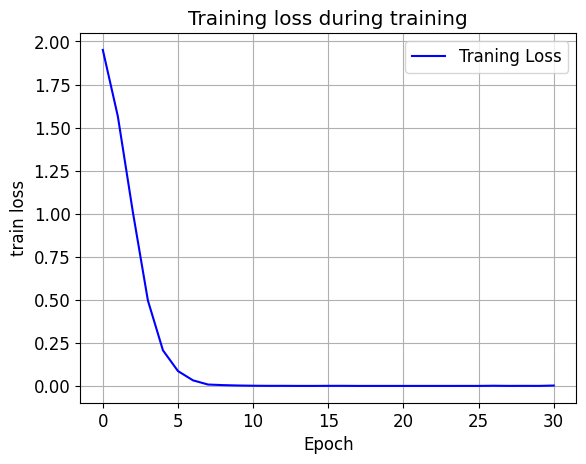

In [141]:
#################################################################
# add your code here to plot the training loss to epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(S_loss_values, 'b-', label='Traning Loss')

# Add a legend to the plot
ax.legend(loc='upper right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('train loss')
ax.set_title('Training loss during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
#################################################################

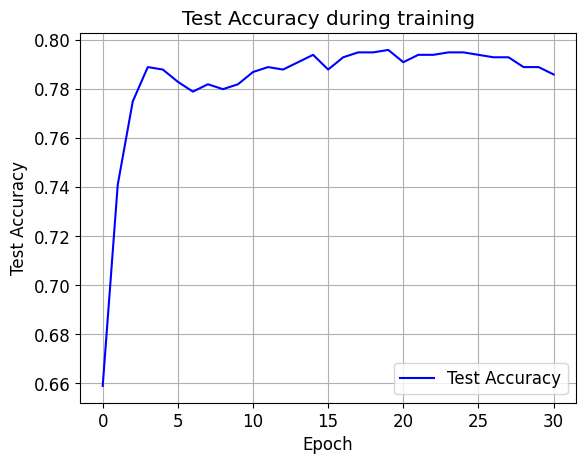

In [142]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(S_accuracy_values, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

___

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

 **(b.1) Define and instantiate a ClusterGCN model with the following parameters:**
  - convolution layer: SAGEConv
  - num_layers: 2
  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 128
  - out_channels: number of classes in Cora
  - learning rate: 0.01
  - train loader batch size: 20
  - test loader batch size: 1024
  - drop out: 0.5
  - num parts: 400
  
  **train it for 20 epochs and record the training loss and accuracy**
  
  **plot the training loss and accuracy on the test set as a function to the epochs**

For clusterGCN, we call the ClusterData from torch_geometric.loader to break the original graphs into communities. Use the number of communities defined above as num_parts. Use the ClusterLoader to build data loader using the communities, specify the batch size as given above.

In [48]:
C_cluster_data = ClusterData(data, num_parts=400, recursive=False, save_dir=cora_dataset.processed_dir)
C_train_loader = ClusterLoader(C_cluster_data, batch_size=20, shuffle=True, num_workers=2)

In [49]:
for batch in C_train_loader:
    print(batch)
    break 

Data(x=[137, 1433], y=[137], train_mask=[137], val_mask=[137], test_mask=[137], edge_index=[2, 192])


In [47]:
C_subgraph_loader = NeighborSampler(
    data.edge_index, 
    sizes=[-1]*2,
    batch_size=1024, 
    shuffle=False, 
    num_workers=2
    )

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

Define and instantiate the ClusterGCN using the SAGEConv layer from torch_geometric package in the following cell

In [50]:
#################################################################
# add your code here to define and instantiate the ClusterGCN
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        # define the layers here
        super(ClusterGCN, self).__init__()
        self.convs = ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.dropout = nn.Dropout(p=0.5)
        
    # define a forward function for the ClusterGCN
    # we should also use batches defined in the loader
    def forward(self, x, edge_index):
      for i, conv in enumerate(self.convs):
          x_target = x
          x = conv(x, edge_index)
          if i != len(self.convs) - 1:
              x = F.relu(x)
              x = self.dropout(x)
      return F.log_softmax(x, dim=1)

    def inference(self, x_all, subgraph_loader):
        for i, conv in enumerate(self.convs):
            xs = []
            for batch_size, n_id, adjs in subgraph_loader:
                edge_index, _, size = adjs[i]
                x_target = x_all[:size[1]]
                x = conv((x_all[n_id], x_target), edge_index)
                if i != len(self.convs) - 1:
                    x = F.relu(x)
                xs.append(x.cpu())
                
            x_all = torch.cat(xs, dim=0)
            
        return F.log_softmax(x_all, dim=1)
#################################################################

In [51]:
#################################################################
# add your code here to train the ClusterGCN for 200 epochs
# and record the training loss and accuracy on test set

# define training function here
def C_train(model, train_loader, optimizer):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index) 
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


# Inference should be performed on the full graph.
@torch.no_grad()
def C_test(model, subgraph_loader):
    model.eval()

    out = model.inference(data.x, subgraph_loader)

    pred = out.argmax(dim=-1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    return acc

In [52]:
# train the model here for 200 epochs
# record the loss and test accuracy during training

C_model = ClusterGCN(1433, 128, 7, 2)
C_optimizer = torch.optim.Adam(C_model.parameters(), lr=0.01)
    
device = torch.device('cpu')
C_model = C_model.to(device)
data = data.to(device)

C_loss_values = []
C_accuracy_values = []

for epoch in range(31):
    loss = C_train(C_model, C_train_loader, C_optimizer)
    acc = C_test(C_model, C_subgraph_loader)
    C_loss_values.append(loss)
    C_accuracy_values.append(acc)
    if epoch % 3 == 0:
      print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))

Epoch: 000, Loss: 1.76804, Acc: 0.32600
Epoch: 003, Loss: 0.03670, Acc: 0.35600
Epoch: 006, Loss: 0.01105, Acc: 0.29200
Epoch: 009, Loss: 0.05751, Acc: 0.32200
Epoch: 012, Loss: 0.00067, Acc: 0.33400
Epoch: 015, Loss: 0.00200, Acc: 0.32400
Epoch: 018, Loss: 0.00029, Acc: 0.30600
Epoch: 021, Loss: 0.00003, Acc: 0.31400
Epoch: 024, Loss: 0.00017, Acc: 0.30800
Epoch: 027, Loss: 0.00017, Acc: 0.31000
Epoch: 030, Loss: 0.00008, Acc: 0.30800


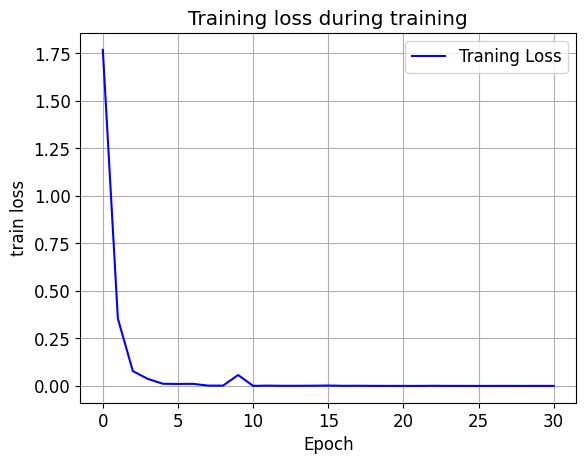

In [53]:
#################################################################
# add your code here to plot the training loss to epochs

def plot_training_loss(loss_values):

  # Set the font size for the plot labels and title
  plt.rcParams.update({'font.size': 12})

  # Create a figure and axis object
  fig, ax = plt.subplots()

  # Plot the training loss as a blue line
  ax.plot(loss_values, 'b-', label='Traning Loss')

  # Add a legend to the plot
  ax.legend(loc='upper right')

  # Set the plot labels and title
  ax.set_xlabel('Epoch')
  ax.set_ylabel('train loss')
  ax.set_title('Training loss during training')

  # Add grid lines to the plot
  ax.grid(True, which='both')

  # Display the plot
  plt.show()

plot_training_loss(C_loss_values)
#################################################################

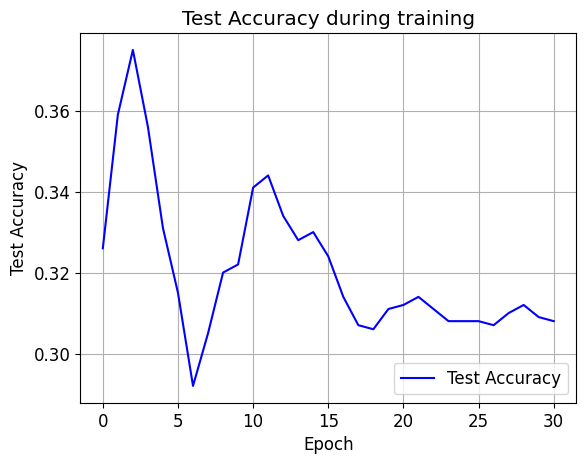

In [54]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

def plot_test_accuracies(acc_values):

  # Set the font size for the plot labels and title
  plt.rcParams.update({'font.size': 12})

  # Create a figure and axis object
  fig, ax = plt.subplots()

  # Plot the training loss as a blue line
  ax.plot(acc_values, 'b-', label='Test Accuracy')

  # Add a legend to the plot
  ax.legend(loc='lower right')

  # Set the plot labels and title
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Test Accuracy')
  ax.set_title('Test Accuracy during training')

  # Add grid lines to the plot
  ax.grid(True, which='both')

  # Display the plot
  plt.show()

plot_test_accuracies(C_accuracy_values)
######################################################################### 

**(b.1)What would happen in the training if we specify a very high number of communities, for example 1500 in the ClusterData object? Implement the ClusterGCN with 1500 communities in the following cell and observe the training loss and test accurracy to draw your conclusion.**

In [55]:
cluster_data_1500 = ClusterData(data, num_parts=1500, recursive=False, save_dir=cora_dataset.processed_dir)
train_loader_1500 = ClusterLoader(cluster_data_1500, batch_size=20, shuffle=True, num_workers=2)

C_subgraph_loader_1500 = NeighborSampler(
    data.edge_index, 
    sizes=[-1]*2,
    batch_size=1024, 
    shuffle=False, 
    num_workers=2
)

C_model_1500 = ClusterGCN(1433, 128, 7, 2)
C_optimizer_1500 = torch.optim.Adam(C_model_1500.parameters(), lr=0.01)

device = torch.device('cpu')
C_model_1500 = C_model_1500.to(device)
data = data.to(device)

C_1500_loss_values = []
C_1500_accuracy_values = []

for epoch in range(31):
    loss = C_train(C_model_1500, train_loader_1500, C_optimizer_1500)
    acc = C_test(C_model_1500, C_subgraph_loader_1500)
    C_1500_loss_values.append(loss)
    C_1500_accuracy_values.append(acc)
    if epoch % 3 == 0:
      print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))


Epoch: 000, Loss: nan, Acc: 0.30800
Epoch: 003, Loss: nan, Acc: 0.32500
Epoch: 006, Loss: nan, Acc: 0.37500
Epoch: 009, Loss: nan, Acc: 0.30700
Epoch: 012, Loss: nan, Acc: 0.31700
Epoch: 015, Loss: nan, Acc: 0.31100
Epoch: 018, Loss: nan, Acc: 0.28200
Epoch: 021, Loss: nan, Acc: 0.30000
Epoch: 024, Loss: nan, Acc: 0.29000
Epoch: 027, Loss: nan, Acc: 0.28600
Epoch: 030, Loss: nan, Acc: 0.26800


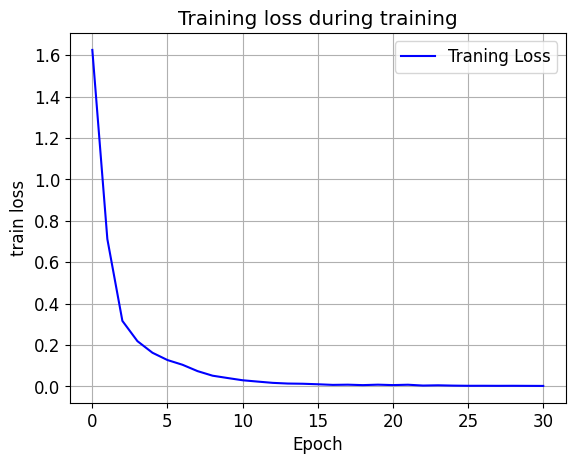

In [18]:
plot_training_loss(C_1500_loss_values)

**Answer Here:**

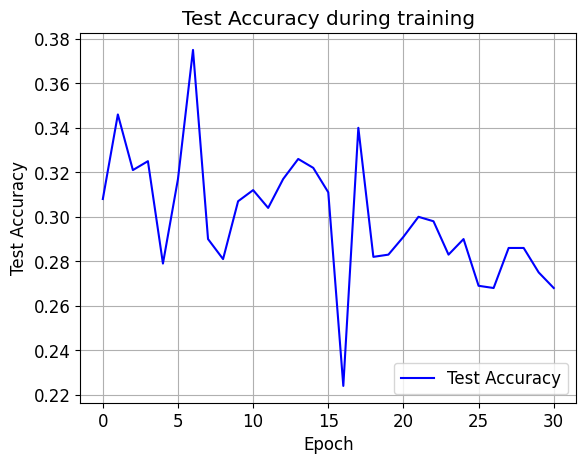

In [59]:
plot_test_accuracies(C_1500_accuracy_values)

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c.1)Which method did you expect to converge faster. Explain why in the following cell**

GraphSAGE samples from neighborhood graphs around each node to perform the computations, while ClusterGCN divides the graph into communities and uses each as a batch to perform SGD updates. In slide 61 of lecture 10 it is stated that the training convergence of stochastic GNNs depends on how well the mini-batches represent the whole data. I would expect ClusterGCN to converge faster since it employs a full-batch strategy with ClusterLoader. Although the subgraphs found by ClusterGCN might contain nodes of same class, GraphSAGE's sampling method results in approximatations from sampled neighborhoods which are not representative of the whole graph.



**(c.2)Which method converges faster in your experiments**

From the graphs plotted above it can be seen that the GraphSAGE model converges after 7 epochs while the ClusterGCN model converges after just 4 epochs. If the number of communities in the ClusterData object is increased to 1500 as in the last experiment, the converge is slower, occuring around 13 epochs. The reason is that a high number of communities results in smaller clusters and the model has less information to use during training and risks poor generalization.


**(c.3)In case your observations about convergence of the compared method differ from your expectations, what could have contributed to this difference?**

The observations about convergence were aligened with the expectations, as ClusterGCN converged faster compared to GraphSAGE's neighborhood sampling method. The decrease in convergence speed observed when the number of communities increased in ClusterGCN supports the idea that smaller clusters result in less information available to the model, needing more epochs to converge. In any case, even though ClusterGCN converges in less epochs the computational time difference is not so clear. If the convergence would have been different it might have been caused by ClusterGCN using subgraphs which are too different from each other and not representative enough. I imagine the best performing method depends on the specific dataset and might vary for other cases.

### 🕵 <font color='289C4E'>Coding Question<font><a class='anchor' id='top'></a>

**(e)Try here 10 and 20 layers of GraphSAGE and ClusterGCN with the same parameters as defined in two layers GraphSAGE and ClusterGCN. From your observations which method would you prefer when increasing the layers and give your reasons in the following cell.**

In [77]:
def plot_loss_and_accuracy(loss_values, acc_values):
  
  # Set the font size for the plot labels and title
  plt.rcParams.update({'font.size': 12})

  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  # Plot the training loss on the first subplot
  ax1.plot(loss_values, 'b-', label='Training Loss')
  ax1.legend(loc='upper right')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Training Loss')
  ax1.set_title('Training loss during training')
  ax1.grid(True, which='both')

  # Plot the test accuracy on the second subplot
  ax2.plot(acc_values, 'b-', label='Test Accuracy')
  ax2.legend(loc='lower right')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Test Accuracy')
  ax2.set_title('Test Accuracy during training')
  ax2.grid(True, which='both')

  # Display the plot
  plt.show()

Epoch: 000, Loss: 1.94809, Acc: 0.31900
Epoch: 003, Loss: 1.93061, Acc: 0.06400
Epoch: 006, Loss: 1.86539, Acc: 0.21300
Epoch: 009, Loss: 1.69352, Acc: 0.16100
Epoch: 012, Loss: 1.80092, Acc: 0.14100
Epoch: 015, Loss: 1.62050, Acc: 0.13600
Epoch: 018, Loss: 1.58479, Acc: 0.31500
Epoch: 021, Loss: 1.59983, Acc: 0.29500
Epoch: 024, Loss: 1.58362, Acc: 0.18800
Epoch: 027, Loss: 1.54378, Acc: 0.16700
Epoch: 030, Loss: 1.56724, Acc: 0.15800


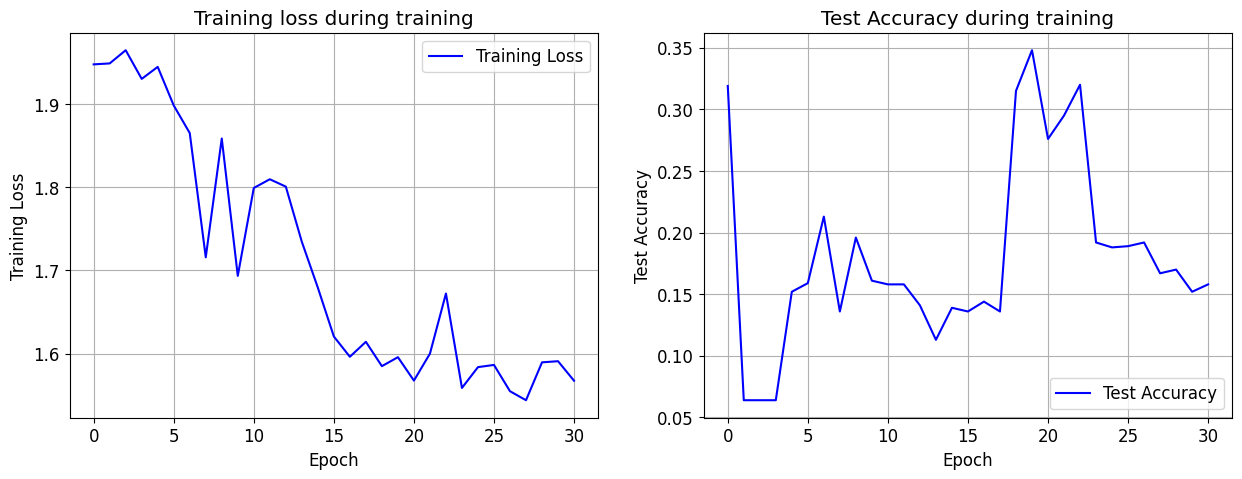

In [145]:
######################################################################### 
#Run 10 layer Graphsage here
model = SAGE(data.num_features, 128, cora_dataset.num_classes, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

device = torch.device('cpu')
model = model.to(device)
data = data.to(device)

S_10_loss_values = []
S_10_accuracy_values = []

for epoch in range(31):
    loss = S_train(model, S_train_loader, optimizer)
    acc = S_test(model, S_subgraph_loader)
    S_10_loss_values.append(loss)
    S_10_accuracy_values.append(acc)

    if epoch % 3 == 0:
      print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))

plot_loss_and_accuracy(S_10_loss_values, S_10_accuracy_values)
######################################################################### 

Epoch: 000, Loss: 1.94783, Acc: 0.13000
Epoch: 003, Loss: 1.95150, Acc: 0.14900
Epoch: 006, Loss: 1.94314, Acc: 0.31800
Epoch: 009, Loss: 1.93433, Acc: 0.14900
Epoch: 012, Loss: 1.93154, Acc: 0.08400
Epoch: 015, Loss: 1.94736, Acc: 0.11700
Epoch: 018, Loss: 1.93293, Acc: 0.14700
Epoch: 021, Loss: 1.91952, Acc: 0.06400
Epoch: 024, Loss: 1.95824, Acc: 0.09400
Epoch: 027, Loss: 1.90308, Acc: 0.08900
Epoch: 030, Loss: 1.93616, Acc: 0.09100


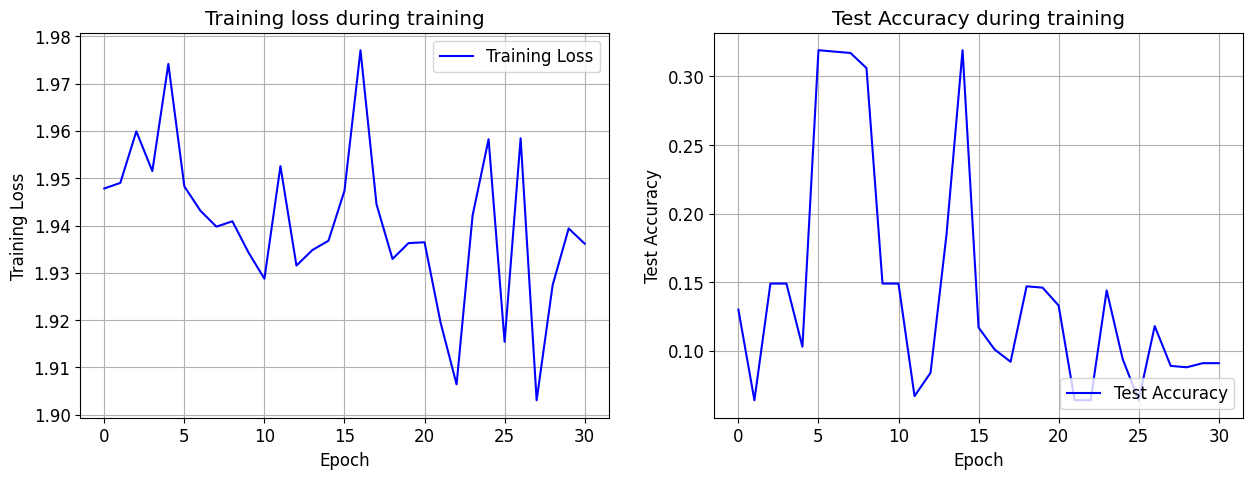

In [148]:
######################################################################### 
#Run 20 layer Graphsage here
model = SAGE(data.num_features, 128, cora_dataset.num_classes, 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

device = torch.device('cpu')
model = model.to(device)
data = data.to(device)

S_20_loss_values = []
S_20_accuracy_values = []

for epoch in range(31):
    loss = S_train(model, S_train_loader, optimizer)
    acc = S_test(model, S_subgraph_loader)
    S_20_loss_values.append(loss)
    S_20_accuracy_values.append(acc)

    if epoch % 3 == 0:
      print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))

plot_loss_and_accuracy(S_20_loss_values, S_20_accuracy_values)
######################################################################### 

In [57]:
######################################################################### 
#Run 10 layer ClusterGCN here

cluster_data_10 = ClusterData(data, num_parts=400, recursive=False, save_dir=cora_dataset.processed_dir)
train_loader_10 = ClusterLoader(cluster_data_10, batch_size=20, shuffle=True, num_workers=2)

C_10_subgraph_loader = NeighborSampler(
    data.edge_index, 
    sizes=[-1]*10,
    batch_size=1024, 
    shuffle=False, 
    num_workers=2
    )

C_10_model = ClusterGCN(1433, 128, 7, 10)
C_10_optimizer = torch.optim.Adam(C_10_model.parameters(), lr=0.01)

device = torch.device('cpu')
C_10_model = C_10_model.to(device)
data = data.to(device)

C_10_loss_values = []
C_10_accuracy_values = []

for epoch in range(31):
    loss = C_train(C_10_model, train_loader_10, C_10_optimizer)
    acc = C_test(C_10_model, C_10_subgraph_loader)
    C_10_loss_values.append(loss)
    C_10_accuracy_values.append(acc)
    if epoch % 3 == 0:
        print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))
  
######################################################################### 

Epoch: 000, Loss: 2.09733, Acc: 0.13000
Epoch: 003, Loss: 1.98764, Acc: 0.31900
Epoch: 006, Loss: 2.41877, Acc: 0.14400
Epoch: 009, Loss: 5.23662, Acc: 0.14400
Epoch: 012, Loss: 10.11182, Acc: 0.09100
Epoch: 015, Loss: 5.77075, Acc: 0.09100
Epoch: 018, Loss: 2.46176, Acc: 0.14400
Epoch: 021, Loss: 7.31653, Acc: 0.09100
Epoch: 024, Loss: 2.15279, Acc: 0.10300
Epoch: 027, Loss: 2.01016, Acc: 0.10300
Epoch: 030, Loss: 1.94793, Acc: 0.14400


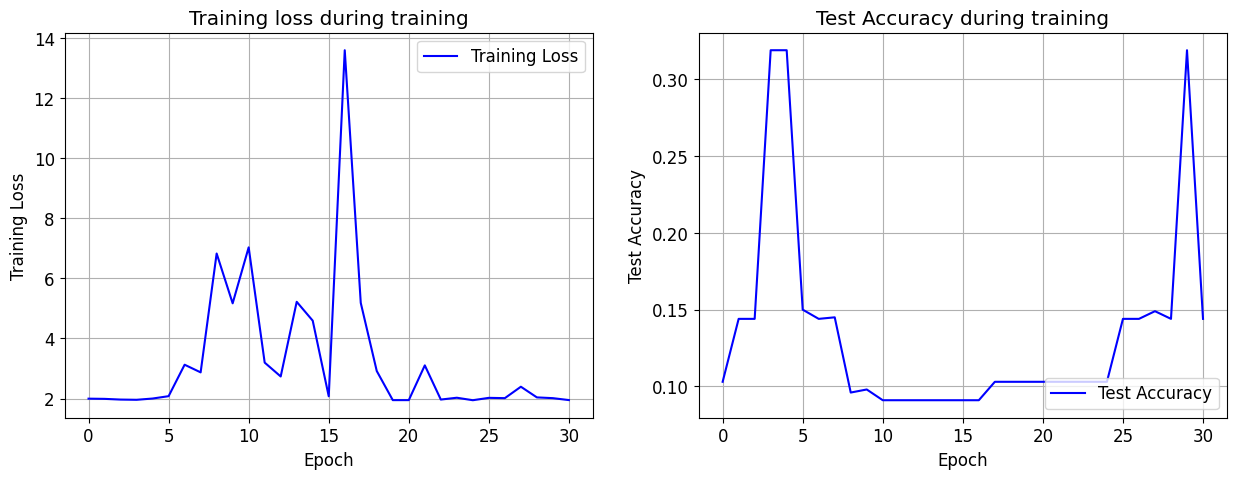

In [78]:
plot_loss_and_accuracy(C_10_loss_values, C_10_accuracy_values)

In [65]:
######################################################################### 
#Run 20 layer ClusterGCN here

cluster_data_20 = ClusterData(data, num_parts=400, recursive=False, save_dir=cora_dataset.processed_dir)
train_loader_20 = ClusterLoader(cluster_data_20, batch_size=20, shuffle=True, num_workers=2)

C_20_subgraph_loader = NeighborSampler(
    data.edge_index, 
    sizes=[-1]*10,
    batch_size=1024, 
    shuffle=False, 
    num_workers=2
    )

C_20_model = ClusterGCN(1433, 128, 7, 10)
C_20_optimizer = torch.optim.Adam(C_20_model.parameters(), lr=0.01)

device = torch.device('cpu')
C_20_model = C_20_model.to(device)
data = data.to(device)

C_20_loss_values = []
C_20_accuracy_values = []

for epoch in range(31):
    loss = C_train(C_20_model, train_loader_20, C_20_optimizer)
    acc = C_test(C_20_model, C_20_subgraph_loader)
    C_20_loss_values.append(loss)
    C_20_accuracy_values.append(acc)
    if epoch % 3 == 0:
        print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch, loss, acc))

######################################################################### 

Epoch: 000, Loss: 2.00465, Acc: 0.12700
Epoch: 003, Loss: 2.01894, Acc: 0.14400
Epoch: 006, Loss: 2.80764, Acc: 0.09100
Epoch: 009, Loss: 2.98783, Acc: 0.10600
Epoch: 012, Loss: 8.56963, Acc: 0.31900
Epoch: 015, Loss: 3.40467, Acc: 0.31900
Epoch: 018, Loss: 4.17380, Acc: 0.31900
Epoch: 021, Loss: 2.01704, Acc: 0.14900
Epoch: 024, Loss: 1.94866, Acc: 0.14900
Epoch: 027, Loss: 3.16165, Acc: 0.14400
Epoch: 030, Loss: 2.07599, Acc: 0.14900


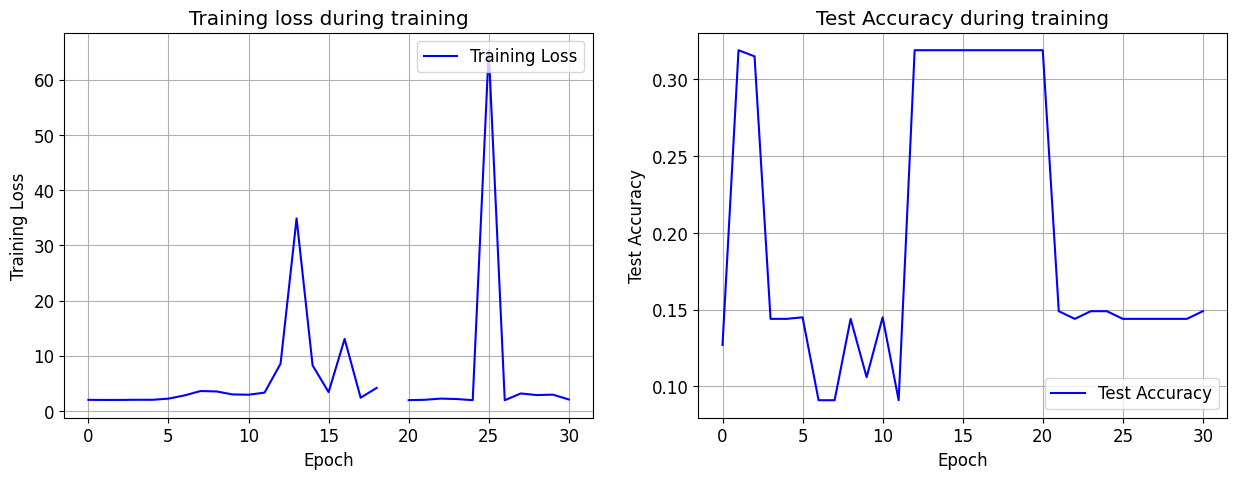

In [79]:
plot_loss_and_accuracy(C_20_loss_values, C_20_accuracy_values)

**Answer here:** 

We would expect deeper networks with more layers to perform better with GraphSAGE since it better controlles neighborhood size, reduces computational complexity and prevents over-smoothing. From the graphs above it can be seen that the behavior of GraphSAGE is much more stable while ClusterGCN suffers from erratic scores and struggles with convergence.

---

## Lab 3.2: Explanability of GNNs

**Description:**

In this section, you will extract and analyse the explainations from GNNExplainer and Zorro on Cora. 

To do this, we firstly train a basic GCN with default parameters to perform the node classification task. This trained GCN will then be used as the target model to explain by the GNNExplainer and Zorro. We randomly choose ten nodes from Cora to produce explanations. The explainations indicate which features and neighboring nodes/edges are crucial for the ego nodes in the node classification task. Finally, we compare and analyse the explanations extracted by GNNExplainera and Zorro using RDT-fidelity and sparsity.



Note the explainers may produce different explanations for different nodes. In order to make the anwser correctable, we randomly choose 10 nodes with indices [116, 198, 224, 650, 808, 1017, 1706, 1733, 2172, 2433] for this question. Run the following code to extract their features from the feature matrix of Cora.

In [150]:
ind = [116, 198, 224, 650, 808, 1017, 1706, 1733, 2172, 2433]
feat = data.x[ind]

Now we train a GCN model with the following parameters for 100 epochs:

  - in_channels: the dimensions of the feature matrix in Cora
  - hidden_channels: 16
  - num_layers: 2
  - out_channels: number of classes in Cora
  - learning rate: 0.01
  - drop out: 0.5
  - weight_decay: 5e-4

In the following cell, we provide the code to define and instanstiate a GCN model using the previouly given parameters:

In [151]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x
    
model = GCN(cora_dataset.num_features, 16, cora_dataset.num_classes)

Now we train the GCN model instantiated in the previous cell for 100 epochs using the built in train, validation, and test split in Cora

In [152]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, test: {test_acc:.4f}')

Epoch: 01, Loss: 1.9499, Train: 0.5857, Val: 0.3480, test: 0.3320
Epoch: 02, Loss: 1.8572, Train: 0.7929, Val: 0.4900, test: 0.5240
Epoch: 03, Loss: 1.7541, Train: 0.8500, Val: 0.5760, test: 0.5990
Epoch: 04, Loss: 1.6246, Train: 0.9214, Val: 0.6280, test: 0.6330
Epoch: 05, Loss: 1.4997, Train: 0.9286, Val: 0.6520, test: 0.6700
Epoch: 06, Loss: 1.3788, Train: 0.9429, Val: 0.6780, test: 0.6820
Epoch: 07, Loss: 1.2347, Train: 0.9571, Val: 0.6960, test: 0.7040
Epoch: 08, Loss: 1.1302, Train: 0.9571, Val: 0.7140, test: 0.7270
Epoch: 09, Loss: 1.0134, Train: 0.9643, Val: 0.7340, test: 0.7460
Epoch: 10, Loss: 0.9071, Train: 0.9643, Val: 0.7480, test: 0.7580
Epoch: 11, Loss: 0.8096, Train: 0.9714, Val: 0.7560, test: 0.7650
Epoch: 12, Loss: 0.7752, Train: 0.9786, Val: 0.7620, test: 0.7690
Epoch: 13, Loss: 0.6582, Train: 0.9786, Val: 0.7720, test: 0.7760
Epoch: 14, Loss: 0.5833, Train: 0.9857, Val: 0.7760, test: 0.7820
Epoch: 15, Loss: 0.5769, Train: 0.9857, Val: 0.7780, test: 0.7880
Epoch: 16,

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(a)Extract explanation for the above mentioned 10 nodes using GNNExplainer using the following parameters:**

    - epochs: 100
    - model: the previously trained GCN
    - top_k: extract importance of top 50 features
    
**GNNExplainer is implemented in torch_geometric. Instantiate GNNExplainer by filling the blanks in the following cell.**
    
**Visualize the importances assigned to each feature by GNNExplainer**

In [153]:
##################################################################################
#add your code here to generate explanations using GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# explanations for each node
explanations = []
for node_idx in ind:
    explanation = explainer(data.x, data.edge_index, index=node_idx)
    explanations.append(explanation)
##################################################################################

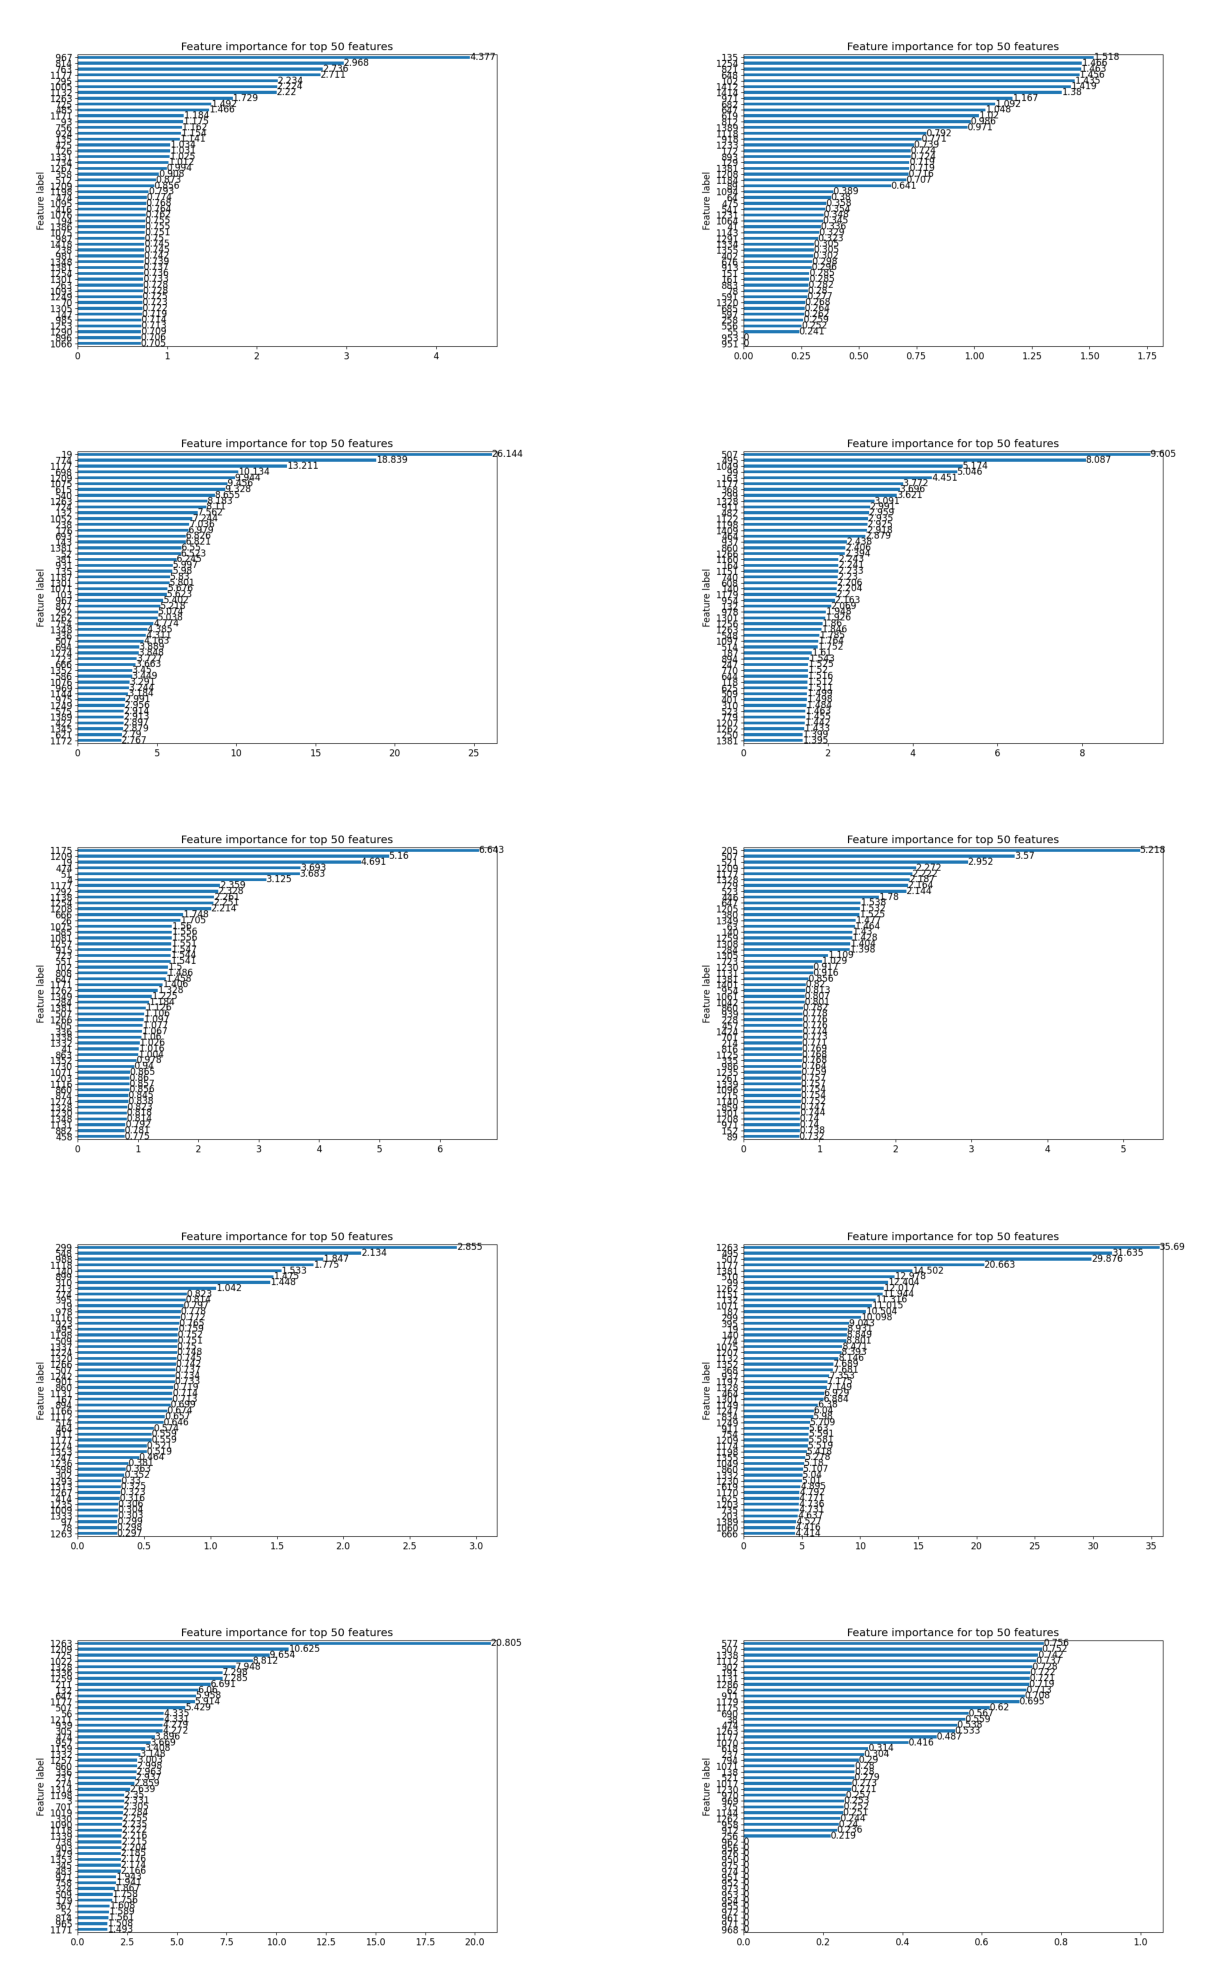

In [185]:
top_k = 50
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()

for i, explanation in enumerate(explanations):
    path = f'feature_importance_{i}.png'
    explanation.visualize_feature_importance(path, top_k=top_k)
    image = plt.imread(path)
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(b)Calculate the RDT fidelity of the explanations extracted from GNNExplainer**

The following function calculate the k-hop subgraph of the given target nodes. This function will be called in the calculation of the RDT-Fidelity.

In [157]:
def subgraph(model, node_idx, x, edge_index, **kwargs):
    num_nodes, num_edges = x.size(0), edge_index.size(1)

    flow = 'source_to_target'
    for module in model.modules():
        if isinstance(module, MessagePassing):
            flow = module.flow
            break

    num_hops = 0
    for module in model.modules():
        if isinstance(module, MessagePassing):
            if isinstance(module, APPNP):
                num_hops += module.K
            else:
                num_hops += 1

    subset, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_idx, num_hops, edge_index, relabel_nodes=True,
        num_nodes=num_nodes, flow=flow)

    x = x[subset]
    for key, item in kwargs:
        if torch.is_tensor(item) and item.size(0) == num_nodes:
            item = item[subset]
        elif torch.is_tensor(item) and item.size(0) == num_edges:
            item = item[edge_mask]
        kwargs[key] = item

    return x, edge_index, mapping, edge_mask, kwargs

Zorro outputs feature_mask and node_mask. In order to make the comparision later between the explainers, use the following code snippet to convert the edge_mask produced by GNNExplainer to node_mask:

In [158]:
def edge_mask_to_node_mask(data, edge_mask, aggregation="mean"):

    node_weights = torch.zeros(data.x.shape[0])

    if aggregation == "sum":

        for weight, nodes in zip(edge_mask, data.edge_index.T):
            node_weights[nodes[0].item()] += weight.item() / 2
            node_weights[nodes[1].item()] += weight.item() / 2

    elif aggregation == "mean":

        node_degrees = torch.zeros(data.x.shape[0])

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] += weight.item()

            node_weights[nodes[1].item()] += weight.item()

            node_degrees[nodes[0].item()] += 1

            node_degrees[nodes[1].item()] += 1

        node_weights = node_weights / node_degrees.clamp(min=1.)

    elif aggregation == "max":

        for weight, nodes in zip(edge_mask, data.edge_index.T):

            node_weights[nodes[0].item()] = max(weight.item(), node_weights[nodes[0].item()])

            node_weights[nodes[1].item()] = max(weight.item(), node_weights[nodes[1].item()])

    else:

        raise NotImplementedError(f"No such aggregation method: {aggregation}")

    return node_weights

In [159]:
# convert the edge mask to node mask here
node_feat_masks = []
for explanation in explanations:
  node_feat_mask = edge_mask_to_node_mask(data, explanation.edge_mask)
  node_feat_masks.append(node_feat_mask)


In the following cell is the incomplete function to calculate the RDT-Fidelity. Read the code and fill the blank in the follwing cell to complete the function of calculating RDT-Fidelity:

In [160]:
# The function to return the k-hop subgraph of the selected nodes
def fidelity(model,  # is a must
             node_idx,  # is a must
             full_feature_matrix,  # must
             edge_index=None,  # the whole, so data.edge_index
             node_mask=None,  # at least one of these three node, feature, edge
             feature_mask=None,
             edge_mask=None,
             samples=100,
             random_seed=12345,
             device="cpu"
             ):
    """
    Distortion/Fidelity (for Node Classification)
    :param model: GNN model which is explained
    :param node_idx: The node which is explained
    :param full_feature_matrix: The feature matrix from the Graph (X)
    :param edge_index: All edges
    :param node_mask: Is a (binary) tensor with 1/0 for each node in the computational graph
    => 1 means the features of this node will be fixed
    => 0 means the features of this node will be pertubed/randomized
    if not available torch.ones((1, num_computation_graph_nodes))
    :param feature_mask: Is a (binary) tensor with 1/0 for each feature
    => 1 means this features is fixed for all nodes with 1
    => 0 means this feature is randomized for all nodes
    if not available torch.ones((1, number_of_features))
    :param edge_mask:
    :param samples:
    :param random_seed:
    :param device:
    :param validity:
    :return:
    """
    if edge_mask is None and feature_mask is None and node_mask is None:
        raise ValueError("At least supply one mask")

    computation_graph_feature_matrix, computation_graph_edge_index, mapping, hard_edge_mask, kwargs = subgraph(model, node_idx, 
                                                                                                               full_feature_matrix, 
                                                                                                               edge_index)

    # get predicted label
    log_logits = model.forward(x=computation_graph_feature_matrix,
                               edge_index=computation_graph_edge_index)
    predicted_labels = log_logits.argmax(dim=-1)

    predicted_label = predicted_labels[mapping]

    # fill missing masks
    if feature_mask is None:
        (num_nodes, num_features) = full_feature_matrix.size()
        feature_mask= torch.ones((1, num_features), device=device)

    num_computation_graph_nodes = computation_graph_feature_matrix.size(0)
    if node_mask is None:
        # all nodes selected
        node_mask = torch.ones((1, num_computation_graph_nodes), device=device)


    # set edge mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = edge_mask
    (num_nodes, num_features) = full_feature_matrix.size()

    num_nodes_computation_graph = computation_graph_feature_matrix.size(0)

    # retrieve complete mask as matrix
    mask = node_mask.T.matmul(feature_mask)

    correct = 0.0

    rng = torch.Generator(device=device)
    rng.manual_seed(random_seed)
    random_indices = torch.randint(num_nodes, (samples, num_nodes_computation_graph, num_features),
                                   generator=rng,
                                   device=device,
                                   )
    random_indices = random_indices.type(torch.int64)
    
    
    ###################################################################################################
    # for each samples, add your code here to:
    for i in range(samples):
      #1. generate the perturbed input
      perturbed = computation_graph_feature_matrix.clone()
      perturbed[mask.bool()] = torch.rand((int(mask.sum()), ), device=device)

      #2. get the prediction from the trained model using the perturbed features as input
      log_logits_perturbed = model.forward(x=perturbed,
                                      edge_index=computation_graph_edge_index)
      predicted_labels_perturbed = log_logits_perturbed.argmax(dim=-1)

      #3. calculate the number of corrected predicted labels:
      correct += (predicted_label == predicted_labels_perturbed[mapping]).sum().item()
    
    ###################################################################################################

    # reset mask
    if edge_mask is not None:
        for module in model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None

    return correct / samples

calculate the RDT-Fidelity of the extracted feature and node explanations:

In [ ]:
# for each node calculate the rdt fidelity for the feature and node mask

fidelity_scores = []

for idx in range(len(explanations)):

    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=100, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)

**Answer here Fidelity for GNNExplainer:**

 The fidelity scores represent the extent to which the model's predictions remain consistent, indicating whether the model relies on the associated information to make accurate predictions. Using the explanations to obtain the fidelity results in the following scores: [0.0, 0.07, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]. It can be seen that most values are 0 while the second one is a quite low 0.07 and the third one the maximum of 1.



### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c)Repeat (a) and (b) to extract explanation for the above mentioned 10 nodes using Zorro with the following parameters:**

    - model:GCN
    - tau: 0.03
    - samples: 100

We provide the implementation of Zorro in this experiment, you can import it from explainer.py using the following code:

In [209]:
from explainer import Zorro

Using the following function to extract explanations for the nodes

In [ ]:
def get_zorro(index):
    # Same as the 0.98 in the paper
    tau = .03
    # only retrieve 1 explanation
    recursion_depth = 1

    zorro = Zorro(model, device="cpu")
    zorro.explain_node(node_idx=index, full_feature_matrix=data.x, edge_index=data.edge_index, tau=tau, recursion_depth=recursion_depth)
    selected_features = zorro.selected_features
    selected_nodes = zorro.selected_nodes

    return selected_features, selected_nodes

extract explanations for the above mentioned 10 nodes using Zorro

In [ ]:
##################################################################################
#add your code here to extract explanations using Zorro
zorro_explanations = []
for idx in ind:
    zorro_explanations.append(get_zorro(idx))

##################################################################################

Argmax 814, 0.049999999999999996: 100%|██████████| 1433/1433 [02:47<00:00,  8.56it/s]


0.04


Argmax 295, 0.019999999999999997: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


0.06


Argmax 814, 0.06: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]              


0.12


Argmax 896, 0.09: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]              


0.21


Argmax 363, 0.07000000000000003: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


0.28


Argmax 725, 0.09999999999999998: 100%|██████████| 10/10 [00:01<00:00,  7.76it/s]


0.38


Argmax 967, 0.14: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


0.52


Argmax 2, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


0.58


Argmax 763, 0.040000000000000036: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


0.65


Argmax 0, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


0.68


Argmax 763, 0.029999999999999916: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


0.71


Argmax 3, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


0.8


Argmax 1290, 0.019999999999999907: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


0.82


Argmax 750, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


0.83


Argmax 0, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


0.84


Argmax 0, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


0.87


Argmax 0, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


0.87


Argmax 1, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


0.87


Argmax 2, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


0.87


Argmax 3, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


0.87


Argmax 4, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


0.88


Argmax 4, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


0.88


Argmax 6, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]                 


0.88


Argmax 7, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]                 


0.88


Argmax 8, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]                 


0.88


Argmax 5, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


0.88


Argmax 9, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


0.88


Argmax 10, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


0.88


Argmax 11, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


0.88


Argmax 19, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


0.89


Argmax 12, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


0.89


Argmax 13, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


0.89


Argmax 14, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


0.89


Argmax 15, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


0.89


Argmax 16, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


0.89


Argmax 26, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


0.9


Argmax 17, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


0.9


Argmax 18, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


0.9


Argmax 20, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


0.9


Argmax 21, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


0.9


Argmax 22, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


0.9


Argmax 23, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


0.9


Argmax 24, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


0.9


Argmax 27, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


0.9


Argmax 28, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


0.9


Argmax 29, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


0.9


Argmax 30, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


0.9


Argmax 31, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


0.9


Argmax 40, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


0.91


Argmax 32, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


0.91


Argmax 33, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.93it/s]


0.91


Argmax 34, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.86it/s]


0.91


Argmax 35, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


0.91


Argmax 36, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


0.91


Argmax 37, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


0.91


Argmax 38, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


0.91


Argmax 41, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


0.91


Argmax 42, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


0.91


Argmax 43, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


0.91


Argmax 44, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


0.91


Argmax 45, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


0.91


Argmax 46, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


0.91


Argmax 47, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


0.91


Argmax 48, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


0.91


Argmax 49, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.94it/s]


0.91


Argmax 50, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


0.91


Argmax 51, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


0.91


Argmax 53, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]                 


0.91


Argmax 54, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]                 


0.91


Argmax 55, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]                 


0.91


Argmax 56, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]                 


0.91


Argmax 57, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.95it/s]                 


0.91


Argmax 58, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]                 


0.91


Argmax 59, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]                 


0.91


Argmax 60, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]                 


0.91


Argmax 61, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]                 


0.91


Argmax 62, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]                 


0.91


Argmax 64, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]                 


0.91


Argmax 65, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]                 


0.91


Argmax 66, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]                 


0.92


Argmax 66, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]                 


0.92


Argmax 67, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]                 


0.92


Argmax 68, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]                 


0.92


Argmax 69, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]                 


0.92


Argmax 70, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]                 


0.92


Argmax 63, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]                 


0.92


Argmax 71, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]                 


0.92


Argmax 72, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.94it/s]                 


0.92


Argmax 73, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]                 


0.92


Argmax 74, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]                 


0.92


Argmax 75, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s]                 


0.92


Argmax 76, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]                 


0.92


Argmax 77, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]                 


0.92


Argmax 78, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]                 


0.92


Argmax 79, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]                 


0.92


Argmax 80, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]                 


0.92


Argmax 81, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]                 


0.92


Argmax 82, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]                 


0.92


Argmax 89, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


0.93


Argmax 84, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.01it/s]                 


0.93


Argmax 85, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]                 


0.93


Argmax 87, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]                 


0.93


Argmax 88, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]                 


0.93


Argmax 90, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]                 


0.93


Argmax 91, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]                 


0.93


Argmax 94, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]                 


0.93


Argmax 95, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]                 


0.93


Argmax 96, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]                 


0.93


Argmax 97, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]                 


0.93


Argmax 98, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]                 


0.93


Argmax 100, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]                


0.93


Argmax 101, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]                


0.93


Argmax 102, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]                


0.93


Argmax 103, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]                


0.93


Argmax 104, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]                


0.93


Argmax 105, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]                


0.93


Argmax 106, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s]                


0.93


Argmax 107, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s]                


0.93


Argmax 108, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]                


0.93


Argmax 109, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]                


0.93


Argmax 110, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]                


0.93


Argmax 111, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]                


0.93


Argmax 112, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]                


0.93


Argmax 113, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]                


0.93


Argmax 114, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]                


0.93


Argmax 115, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]                


0.93


Argmax 116, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]                


0.93


Argmax 117, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]                


0.93


Argmax 118, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]                


0.93


Argmax 119, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]                


0.93


Argmax 120, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]                


0.93


Argmax 121, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]                


0.93


Argmax 123, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]                


0.93


Argmax 124, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]                


0.93


Argmax 125, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]                


0.93


Argmax 83, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]                 


0.93


Argmax 127, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]                


0.93


Argmax 128, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]                


0.93


Argmax 129, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]                


0.93


Argmax 130, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]                


0.93


Argmax 132, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]                


0.93


Argmax 136, 0.009999999999999898: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


0.94


Argmax 52, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


0.94


Argmax 86, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


0.94


Argmax 133, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]                


0.94


Argmax 134, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]                


0.94


Argmax 138, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s]                


0.94


Argmax 139, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]                


0.94


Argmax 141, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]                


0.94


Argmax 143, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]                


0.94


Argmax 142, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]                


0.94


Argmax 92, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


0.94


Argmax 147, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


0.95


Argmax 99, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]                 


0.95


Argmax 137, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]                


0.95


Argmax 140, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]                


0.95


Argmax 144, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]                


0.95


Argmax 145, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]                


0.95


Argmax 146, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]                


0.95


Argmax 148, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]                


0.95


Argmax 149, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]                


0.95


Argmax 150, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]                


0.95


Argmax 151, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]                


0.95


Argmax 152, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.04it/s]                


0.95


Argmax 153, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]                


0.95


Argmax 154, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]                


0.95


Argmax 155, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]                


0.95


Argmax 156, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]                


0.95


Argmax 93, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


0.95


Argmax 158, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]                 


0.95


Argmax 159, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]                 


0.95


Argmax 160, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]                 


0.95


Argmax 161, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]                 


0.95


Argmax 162, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]                 


0.95


Argmax 169, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


0.96


Argmax 163, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]                 


0.96


Argmax 164, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s]                 


0.96


Argmax 165, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]                 


0.96


Argmax 166, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]                 


0.96


Argmax 167, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]                 


0.96


Argmax 168, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s]                 


0.96


Argmax 170, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]                 


0.96


Argmax 171, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]                 


0.96


Argmax 172, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]                 


0.96


Argmax 173, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]                 


0.96


Argmax 174, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]                 


0.96


Argmax 175, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s]                 


0.96


Argmax 176, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]                 


0.96


Argmax 177, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]                 


0.96


Argmax 178, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]                 


0.96


Argmax 179, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]                 


0.96


Argmax 180, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s]                 


0.96


Argmax 181, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]                 


0.96


Argmax 182, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.72it/s]                 


0.96


Argmax 183, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]                 


0.96


Argmax 184, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]                 


0.96


Argmax 185, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]                 


0.96


Argmax 186, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]                 


0.96


Argmax 187, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]                 


0.96


Argmax 188, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]                 


0.96


Argmax 189, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]                 


0.96


Argmax 190, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]                 


0.96


Argmax 191, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]                 


0.96


Argmax 192, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]                 


0.96


Argmax 193, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]                 


0.96


Argmax 194, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]                 


0.96


Argmax 195, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]                 


0.96


Argmax 196, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]                 


0.96


Argmax 197, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]                 


0.96


Argmax 198, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]                 


0.96


Argmax 199, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]                 


0.96


Argmax 200, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]                 


0.96


Argmax 201, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]                 


0.96


Argmax 202, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]                 


0.96


Argmax 203, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]                 


0.96


Argmax 204, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]                 


0.96


Argmax 205, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]                 


0.96


Argmax 206, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]                 


0.96


Argmax 207, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]                 


0.96


Argmax 208, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]                 


0.96


Argmax 209, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]                 


0.96


Argmax 210, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]                 


0.96


Argmax 211, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]                 


0.96


Argmax 212, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s]                 


0.96


Argmax 213, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]                 


0.96


Argmax 214, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.29it/s]                 


0.96


Argmax 215, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]                 


0.96


Argmax 216, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]                 


0.96


Argmax 217, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]                 


0.96


Argmax 218, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]                 


0.96


Argmax 219, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]                 


0.96


Argmax 220, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]                 


0.96


Argmax 221, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]                 


0.96


Argmax 222, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]                 


0.96


Argmax 223, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]                 


0.96


Argmax 224, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]                 


0.96


Argmax 225, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]                 


0.96


Argmax 226, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.46it/s]                 


0.96


Argmax 227, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]                 


0.96


Argmax 228, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]                 


0.96


Argmax 229, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]                 


0.96


Argmax 230, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]                 


0.96


Argmax 231, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]                 


0.96


Argmax 232, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.64it/s]                 


0.96


Argmax 233, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]                 


0.96


Argmax 234, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]                 


0.96


Argmax 235, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]                 


0.96


Argmax 236, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]                 


0.96


Argmax 237, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]                 


0.96


Argmax 238, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]                 


0.96


Argmax 239, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]                 


0.96


Argmax 240, 0.0: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]                 


0.96


Argmax 241, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]                 


0.96


Argmax 242, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]                 


0.96


Argmax 243, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]                 


0.96


Argmax 244, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]                 


0.96


Argmax 245, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s]                 


0.96


Argmax 246, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]                 


0.96


Argmax 247, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]                 


0.96


Argmax 248, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]                 


0.96


Argmax 249, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]                 


0.96


Argmax 250, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.93it/s]                 


0.96


Argmax 251, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]                 


0.96


Argmax 252, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.96it/s]                 


0.96


Argmax 253, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]                 


0.96


Argmax 254, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.01it/s]                 


0.96


Argmax 261, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


0.97


Argmax 255, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s]                 


0.97


Argmax 263, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


0.99


Argmax 1254, 0.21999999999999997: 100%|██████████| 1433/1433 [02:16<00:00, 10.53it/s]


0.26


Argmax 1254, 0.13: 100%|██████████| 10/10 [00:01<00:00,  9.98it/s]             


0.39


Argmax 648, 0.13: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]              


0.52


Argmax 102, 0.15000000000000002: 100%|██████████| 10/10 [00:00<00:00, 10.23it/s]


0.67


Argmax 821, 0.1499999999999999: 100%|██████████| 10/10 [00:00<00:00, 10.20it/s]


0.86


Argmax 172, 0.06000000000000005: 100%|██████████| 10/10 [00:01<00:00,  9.89it/s]


0.92


Argmax 129, 0.029999999999999916: 100%|██████████| 10/10 [00:00<00:00, 10.21it/s]


0.95


Argmax 132, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


0.97


Explain node 198:   0%|          | 9/4299 [02:26<19:23:41, 16.28s/it]

0.99



Argmax 19, 0.25: 100%|██████████| 1433/1433 [05:33<00:00,  4.30it/s]             


0.59


Argmax 774, 0.15000000000000002: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


0.74


Argmax 19, 0.07000000000000006: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


0.81


Argmax 176, 0.07999999999999996: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


0.89


Argmax 698, 0.07999999999999996: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


0.97


Argmax 540, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


0.98


Argmax 495, 0.38999999999999996: 100%|██████████| 1433/1433 [03:53<00:00,  6.14it/s]


0.08


Argmax 10, 0.03: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]              


0.11


Argmax 507, 0.020000000000000004: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


0.14


Argmax 507, 0.03: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]               


0.17


Argmax 140, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]                


0.25


Argmax 163, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


0.35


Argmax 163, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


0.37


Argmax 99, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


0.38


Argmax 140, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


0.5


Argmax 250, 0.050000000000000044: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


0.56


Argmax 250, 0.05999999999999994: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


0.62


Argmax 140, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


0.66


Argmax 52, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


0.72


Argmax 140, 0.050000000000000044: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


0.83


Argmax 39, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


0.84


Argmax 132, 0.040000000000000036: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


0.88


Argmax 456, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


0.89


Argmax 52, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


0.89


Argmax 140, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


0.91


Argmax 135, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


0.92


Argmax 135, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


0.93


Argmax 299, 0.009999999999999898: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


0.94


Argmax 135, 0.0: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


0.95


Argmax 1049, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


0.97


Argmax 135, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


0.97


Argmax 151, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


0.97


Argmax 237, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


0.97


Argmax 247, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


0.97


Argmax 368, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


0.98


Argmax 51, 0.53: 100%|██████████| 1433/1433 [03:44<00:00,  6.39it/s]            


0.27


Argmax 7, 0.22999999999999998: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


0.5


Argmax 774, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


0.6


Argmax 1175, 0.13: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]              


0.73


Argmax 774, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


0.78


Argmax 1254, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


0.81


Argmax 666, 0.029999999999999916: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


0.84


Argmax 774, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


0.89


Argmax 774, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


0.9


Argmax 1413, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


0.92


Argmax 102, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]                


0.92


Argmax 244, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]                


0.92


Argmax 263, 0.0: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]                


0.92


Argmax 287, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]                


0.92


Argmax 95, 0.0: 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]                 


0.92


Argmax 130, 0.0: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s]                


0.94


Argmax 130, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


0.96


Argmax 77, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


0.96


Argmax 130, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


0.96


Argmax 336, 0.0: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


0.97


Argmax 336, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


0.99


Argmax 140, 0.56: 100%|██████████| 1433/1433 [03:29<00:00,  6.85it/s]              


0.11


Argmax 7, 0.21000000000000002: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


0.32


Argmax 368, 0.16999999999999998: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


0.49


Argmax 63, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


0.68


Argmax 507, 0.04999999999999993: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


0.73


Argmax 1263, 0.040000000000000036: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


0.78


Argmax 19, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


0.82


Argmax 1263, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


0.85


Argmax 63, 0.040000000000000036: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


0.9


Argmax 63, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


0.93


Argmax 52, 0.009999999999999898: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


0.95


Argmax 19, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


0.96


Argmax 118, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


0.98


Argmax 299, 0.12999999999999998: 100%|██████████| 1433/1433 [02:29<00:00,  9.58it/s]


0.22


Argmax 495, 0.16: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]              


0.38


Argmax 901, 0.15000000000000002: 100%|██████████| 10/10 [00:01<00:00,  9.26it/s] 


0.53


Argmax 299, 0.08999999999999997: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s] 


0.62


Argmax 310, 0.08999999999999997: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


0.71


Argmax 509, 0.040000000000000036: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


0.76


Argmax 140, 0.06999999999999995: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


0.83


Argmax 548, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


0.85


Argmax 1263, 0.07000000000000006: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


0.92


Argmax 167, 0.019999999999999907: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


0.94


Argmax 213, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


0.94


Argmax 548, 0.020000000000000018: 100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


0.96


Explain node 1706:   0%|          | 13/8598 [02:49<31:05:55, 13.04s/it]

0.98



Argmax 510, 0.05: 100%|██████████| 1433/1433 [13:10<00:00,  1.81it/s]             


0.02


Argmax 52, 0.009999999999999998: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.03


Argmax 4, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


0.03


Argmax 7, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


0.03


Argmax 19, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.03


Argmax 55, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.03


Argmax 85, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.03


Argmax 93, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


0.03


Argmax 99, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


0.03


Argmax 121, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


0.03


Argmax 124, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


0.03


Argmax 125, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


0.03


Argmax 128, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


0.03


Argmax 131, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


0.03


Argmax 135, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


0.03


Argmax 140, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


0.03


Argmax 143, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


0.03


Argmax 176, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.03


Argmax 187, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.03


Argmax 581, 0.010000000000000002: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


0.04


Argmax 196, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


0.04


Argmax 212, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


0.04


Argmax 218, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.05


Argmax 510, 0.05: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]               


0.1


Argmax 299, 0.01999999999999999: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


0.12


Argmax 235, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


0.14


Argmax 823, 0.01999999999999999: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


0.16


Argmax 218, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


0.22


Argmax 310, 0.01999999999999999: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


0.24


Argmax 235, 0.030000000000000027: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


0.27


Argmax 335, 0.02999999999999997: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


0.3


Argmax 261, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


0.31


Argmax 395, 0.06: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]               


0.37


Argmax 330, 0.020000000000000018: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.39


Argmax 238, 0.019999999999999962: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


0.41


Argmax 422, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


0.42


Argmax 218, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.43


Argmax 218, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.43


Argmax 228, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.43


Argmax 234, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


0.43


Argmax 237, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


0.43


Argmax 494, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


0.44


Argmax 368, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


0.46


Argmax 274, 0.0: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


0.47


Argmax 274, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


0.47


Argmax 540, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


0.48


Argmax 547, 0.040000000000000036: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


0.52


Argmax 333, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


0.53


Argmax 592, 0.039999999999999925: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


0.57


Argmax 398, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


0.58


Argmax 495, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


0.59


Argmax 412, 0.0: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]                 


0.6


Argmax 412, 0.0: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]                 


0.6


Argmax 643, 0.020000000000000018: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


0.62


Argmax 428, 0.0: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]                 


0.62


Argmax 429, 0.0: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                 


0.62


Argmax 431, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                 


0.62


Argmax 442, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                 


0.62


Argmax 722, 0.020000000000000018: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


0.64


Argmax 695, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


0.66


Argmax 695, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


0.67


Argmax 726, 0.010000000000000009: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


0.68


Argmax 368, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


0.68


Argmax 744, 0.07999999999999996: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s] 


0.76


Argmax 724, 0.020000000000000018: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


0.78


Argmax 754, 0.039999999999999925: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


0.82


Argmax 666, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


0.84


Argmax 586, 0.0: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


0.84


Argmax 610, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


0.84


Argmax 774, 0.020000000000000018: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


0.86


Argmax 666, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


0.87


Argmax 637, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]                 


0.87


Argmax 700, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]                 


0.87


Argmax 706, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]                 


0.87


Argmax 750, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]                 


0.87


Argmax 755, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]                 


0.87


Argmax 612, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


0.87


Argmax 776, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]                 


0.87


Argmax 860, 0.020000000000000018: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


0.89


Argmax 778, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]                 


0.89


Argmax 807, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]                 


0.89


Argmax 812, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]                 


0.89


Argmax 813, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]                 


0.89


Argmax 814, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]                 


0.89


Argmax 945, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


0.9


Argmax 834, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]                 


0.9


Argmax 779, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]                 


0.9


Argmax 879, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]                 


0.9


Argmax 911, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]                 


0.9


Argmax 1004, 0.030000000000000027: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


0.93


Argmax 773, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]                 


0.93


Argmax 915, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]                 


0.93


Argmax 926, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]                 


0.93


Argmax 1049, 0.009999999999999898: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


0.94


Argmax 939, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]                 


0.95


Argmax 939, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]                 


0.98


Argmax 1336, 0.24999999999999997: 100%|██████████| 1433/1433 [04:57<00:00,  4.82it/s]


0.16


Argmax 1336, 0.11000000000000001: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


0.27


Argmax 647, 0.07: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]              


0.34


Argmax 1259, 0.12: 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]             


0.46


Argmax 738, 0.11999999999999994: 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


0.61


Argmax 738, 0.14: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]              


0.75


Argmax 1263, 0.06000000000000005: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


0.81


Argmax 305, 0.04999999999999993: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


0.89


Argmax 305, 0.04999999999999993: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


0.94


Argmax 19, 0.020000000000000018: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


0.96


Argmax 326, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


0.97


Argmax 93, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


0.98


Argmax 1175, 0.16999999999999998: 100%|██████████| 1433/1433 [02:01<00:00, 11.78it/s]


0.24


Argmax 1175, 0.18: 100%|██████████| 10/10 [00:00<00:00, 10.97it/s]             


0.42


Argmax 474, 0.21000000000000002: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


0.63


Argmax 912, 0.09999999999999998: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


0.73


Argmax 132, 0.040000000000000036: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


0.77


Argmax 89, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


0.77


Argmax 52, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.24it/s]


0.77


Argmax 138, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


0.77


Argmax 261, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.92it/s]


0.78


Argmax 958, 0.039999999999999925: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


0.82


Argmax 1144, 0.020000000000000018: 100%|██████████| 10/10 [00:00<00:00, 10.94it/s]


0.84


Argmax 618, 0.020000000000000018: 100%|██████████| 10/10 [00:00<00:00, 11.24it/s]


0.86


Argmax 794, 0.030000000000000027: 100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


0.89


Argmax 969, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


0.92


Argmax 764, 0.019999999999999907: 100%|██████████| 10/10 [00:00<00:00, 10.06it/s]


0.94


Argmax 1336, 0.010000000000000009: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


0.95


Argmax 261, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s]


0.95


Argmax 2, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.87it/s]


0.95


Argmax 49, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.87it/s]


0.95


Argmax 64, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s]


0.95


Argmax 93, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.25it/s]


0.95


Argmax 99, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]


0.96


Argmax 130, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.19it/s]


0.96


Argmax 140, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


0.96


Argmax 182, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


0.96


Argmax 187, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


0.96


Argmax 233, 0.0: 100%|██████████| 10/10 [00:01<00:00,  9.03it/s]


0.96


Argmax 274, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


0.96


Argmax 297, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


0.96


Argmax 326, 0.0: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


0.96


Argmax 339, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


0.96


Argmax 345, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.67it/s]


0.96


Argmax 359, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.91it/s]


0.96


Argmax 367, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.37it/s]


0.96


Argmax 375, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.07it/s]


0.96


Argmax 393, 0.010000000000000009: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s]


0.97


Argmax 379, 0.0: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


0.97


Argmax 402, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.49it/s]


0.97


Argmax 428, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]


0.97


Argmax 440, 0.0: 100%|██████████| 10/10 [00:00<00:00, 12.09it/s]


0.97


Argmax 475, 0.0: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]         


0.97


Argmax 510, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.73it/s]                 


0.97


Argmax 536, 0.0: 100%|██████████| 10/10 [00:00<00:00, 10.75it/s]                 


0.97


Explain node 2433:   2%|▏         | 44/2866 [02:46<2:58:25,  3.79s/it]

0.98


In [210]:
def get_zorro(index):
    # Same as the 0.98 in the paper
    tau = .03
    # only retrieve 1 explanation
    recursion_depth = 1

    zorro = Zorro(model, device="cpu")
    explanation = zorro.explain_node(index, data.x, data.edge_index, tau=tau, recursion_depth=recursion_depth)
    selected_nodes, selected_features, executed_selections = explanation[0]

    return selected_features[0], selected_nodes[0]

In [ ]:
##################################################################################
#add your code here to extract explanations using Zorro
z_explanations = []
for idx in ind:
    z_explanations.append(get_zorro(idx))

##################################################################################


Argmax 814, 0.08: 100%|██████████| 1433/1433 [05:18<00:00,  4.50it/s]

Explain node 116:   0%|          | 1/12897 [05:21<1150:41:29, 321.22s/it]

0.05


Argmax 814, 0.08: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

Explain node 116:   0%|          | 2/12897 [05:24<481:29:46, 134.42s/it] 

0.13


Argmax 725, 0.06: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

Explain node 116:   0%|          | 3/12897 [05:30<270:08:32, 75.42s/it] 

0.19


Argmax 295, 0.04999999999999999: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

Explain node 116:   0%|          | 4/12897 [05:34<169:27:56, 47.32s/it]

0.24


Argmax 967, 0.06: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

Explain node 116:   0%|          | 5/12897 [05:40<116:33:43, 32.55s/it]

0.3


Argmax 896, 0.10999999999999999: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

Explain node 116:   0%|          | 6/12897 [05:44<81:35:42, 22.79s/it] 

0.41


Argmax 1331, 0.10000000000000003: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

Explain node 116:   0%|          | 7/12897 [05:48<59:25:59, 16.60s/it]

0.51


Argmax 363, 0.07999999999999996: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

Explain node 116:   0%|          | 8/12897 [05:54<47:39:08, 13.31s/it]

0.61


Argmax 363, 0.020000000000000018: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]

Explain node 116:   0%|          | 9/12897 [05:58<36:49:11, 10.28s/it]

0.63


Argmax 126, 0.050000000000000044: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]

Explain node 116:   0%|          | 10/12897 [06:01<29:24:32,  8.22s/it]

0.68


Argmax 485, 0.04999999999999993: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

Explain node 116:   0%|          | 11/12897 [06:06<25:45:30,  7.20s/it]

0.74


Argmax 485, 0.06000000000000005: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]

Explain node 116:   0%|          | 12/12897 [06:10<21:48:03,  6.09s/it]

0.8


Argmax 756, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  5.00it/s]

Explain node 116:   0%|          | 13/12897 [06:13<18:54:40,  5.28s/it]

0.82


Argmax 1325, 0.040000000000000036: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

Explain node 116:   0%|          | 14/12897 [06:19<19:22:57,  5.42s/it]

0.86


Argmax 147, 0.0: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

Explain node 116:   0%|          | 15/12897 [06:26<20:39:59,  5.78s/it]

0.86


Argmax 156, 0.0: 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

Explain node 116:   0%|          | 16/12897 [06:30<18:47:26,  5.25s/it]

0.86


Argmax 194, 0.0: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

Explain node 116:   0%|          | 17/12897 [06:35<18:41:04,  5.22s/it]

0.87


Argmax 763, 0.07999999999999996: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

Explain node 116:   0%|          | 18/12897 [06:39<17:07:31,  4.79s/it]

0.95


Argmax 263, 0.030000000000000027: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]

Explain node 116:   0%|          | 19/12897 [06:43<16:33:05,  4.63s/it]

0.98


Explain node 116:   0%|          | 19/12897 [06:43<76:03:24, 21.26s/it]

Argmax 1254, 0.33999999999999997: 100%|██████████| 1433/1433 [04:16<00:00,  5.58it/s]

Explain node 198:   0%|          | 1/4299 [04:19<309:19:59, 259.10s/it]

0.17


Argmax 1254, 0.16: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]

Explain node 198:   0%|          | 2/4299 [04:21<128:55:51, 108.02s/it]

0.33


Argmax 102, 0.23999999999999994: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

Explain node 198:   0%|          | 3/4299 [04:24<71:41:00, 60.07s/it]  

0.57


Argmax 821, 0.14: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]

Explain node 198:   0%|          | 4/4299 [04:26<44:29:13, 37.29s/it]

0.86


Argmax 821, 0.07000000000000006: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]

Explain node 198:   0%|          | 5/4299 [04:29<29:25:10, 24.66s/it]

0.93


Argmax 172, 0.029999999999999916: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]

Explain node 198:   0%|          | 6/4299 [04:31<20:16:48, 17.01s/it]

0.96


Argmax 648, 0.030000000000000027: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

Explain node 198:   0%|          | 7/4299 [04:34<15:01:42, 12.61s/it]

0.99


Explain node 198:   0%|          | 7/4299 [04:35<46:50:15, 39.29s/it]

Argmax 19, 0.28: 100%|██████████| 1433/1433 [22:29<00:00,  1.06it/s]

Explain node 224:   0%|          | 1/120372 [23:56<48015:34:37, 1436.03s/it]

0.61


Argmax 774, 0.12: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

Explain node 224:   0%|          | 2/120372 [24:06<19970:02:28, 597.26s/it] 

0.73


Argmax 19, 0.13: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

Explain node 224:   0%|          | 3/120372 [24:24<11129:16:12, 332.85s/it]

0.86


Argmax 698, 0.07000000000000006: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

Explain node 224:   0%|          | 4/120372 [24:43<6990:55:31, 209.09s/it] 

0.93


Argmax 176, 0.009999999999999898: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]

Explain node 224:   0%|          | 5/120372 [25:02<4693:25:10, 140.37s/it]

0.94


Argmax 981, 0.040000000000000036: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

Explain node 224:   0%|          | 6/120372 [25:22<3326:42:50, 99.50s/it] 

0.98


Explain node 224:   0%|          | 6/120372 [25:24<8493:00:19, 254.02s/it]

Argmax 495, 0.22: 100%|██████████| 1433/1433 [09:24<00:00,  2.54it/s]

Explain node 650:   0%|          | 1/40124 [09:37<6435:42:15, 577.44s/it]

0.02


Argmax 10, 0.02: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

Explain node 650:   0%|          | 2/40124 [09:41<2674:28:11, 239.97s/it]

0.04


Argmax 507, 0.030000000000000006: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

Explain node 650:   0%|          | 3/40124 [09:49<1496:30:46, 134.28s/it]

0.09


Argmax 507, 0.03: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

Explain node 650:   0%|          | 4/40124 [09:57<937:55:19, 84.16s/it]  

0.12


Argmax 368, 0.03: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

Explain node 650:   0%|          | 5/40124 [10:05<634:04:06, 56.90s/it]

0.16


Argmax 368, 0.04000000000000001: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

Explain node 650:   0%|          | 6/40124 [10:13<449:34:28, 40.34s/it]

0.22


Argmax 299, 0.01999999999999999: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

Explain node 650:   0%|          | 7/40124 [10:21<330:46:42, 29.68s/it]

0.27


Argmax 299, 0.02999999999999997: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Explain node 650:   0%|          | 8/40124 [10:31<261:48:58, 23.50s/it]

0.31


Argmax 368, 0.03999999999999998: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Explain node 650:   0%|          | 9/40124 [10:43<219:22:07, 19.69s/it]

0.36


Argmax 368, 0.030000000000000027: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Explain node 650:   0%|          | 10/40124 [10:50<178:08:03, 15.99s/it]

0.39


Argmax 299, 0.03999999999999998: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

Explain node 650:   0%|          | 11/40124 [11:02<165:12:25, 14.83s/it]

0.46


Argmax 299, 0.12999999999999995: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

Explain node 650:   0%|          | 12/40124 [11:15<158:05:57, 14.19s/it]

0.59


Argmax 1049, 0.06000000000000005: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

Explain node 650:   0%|          | 13/40124 [11:26<144:56:43, 13.01s/it]

0.67


Argmax 247, 0.029999999999999916: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

Explain node 650:   0%|          | 14/40124 [11:34<130:47:06, 11.74s/it]

0.74


Argmax 99, 0.040000000000000036: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

Explain node 650:   0%|          | 15/40124 [11:44<123:20:36, 11.07s/it]

0.81


Argmax 247, 0.039999999999999925: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Explain node 650:   0%|          | 16/40124 [11:54<120:08:23, 10.78s/it]

0.85


Argmax 99, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

Explain node 650:   0%|          | 17/40124 [12:04<118:43:46, 10.66s/it]

0.87


Argmax 140, 0.06000000000000005: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

Explain node 650:   0%|          | 18/40124 [12:13<113:07:00, 10.15s/it]

0.93


Argmax 99, 0.019999999999999907: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

Explain node 650:   0%|          | 19/40124 [12:23<112:50:11, 10.13s/it]

0.95


Argmax 3, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Explain node 650:   0%|          | 20/40124 [12:34<114:39:14, 10.29s/it]

0.98


Explain node 650:   0%|          | 20/40124 [12:35<420:40:34, 37.76s/it]

Argmax 51, 0.51: 100%|██████████| 1433/1433 [08:15<00:00,  2.89it/s]

Explain node 808:   0%|          | 1/30093 [08:25<4222:02:20, 505.10s/it]

0.18


Argmax 5, 0.13: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

Explain node 808:   0%|          | 2/30093 [08:28<1753:38:27, 209.80s/it]

0.31


Argmax 1175, 0.13: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

Explain node 808:   0%|          | 3/30093 [08:35<981:02:42, 117.37s/it] 

0.44


Argmax 1254, 0.03999999999999998: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

Explain node 808:   0%|          | 4/30093 [08:41<613:56:18, 73.45s/it] 

0.5


Argmax 1254, 0.18000000000000005: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

Explain node 808:   0%|          | 5/30093 [08:48<414:17:12, 49.57s/it]

0.68


Argmax 1413, 0.009999999999999898: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

Explain node 808:   0%|          | 6/30093 [08:55<290:52:03, 34.80s/it]

0.77


Argmax 774, 0.020000000000000018: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

Explain node 808:   0%|          | 7/30093 [09:03<219:16:53, 26.24s/it]

0.79


Argmax 1263, 0.020000000000000018: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

Explain node 808:   0%|          | 8/30093 [09:11<170:36:56, 20.42s/it]

0.81


Argmax 1301, 0.019999999999999907: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

Explain node 808:   0%|          | 9/30093 [09:20<141:25:11, 16.92s/it]

0.83


Argmax 1413, 0.020000000000000018: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Explain node 808:   0%|          | 10/30093 [09:29<119:38:19, 14.32s/it]

0.85


Argmax 1209, 0.010000000000000009: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

Explain node 808:   0%|          | 11/30093 [09:37<103:39:22, 12.40s/it]

0.9


Argmax 287, 0.0: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

Explain node 808:   0%|          | 12/30093 [09:44<90:55:48, 10.88s/it] 

0.91


Argmax 1209, 0.010000000000000009: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Explain node 808:   0%|          | 13/30093 [09:54<88:40:39, 10.61s/it]

0.94


Argmax 4, 0.010000000000000009: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Explain node 808:   0%|          | 14/30093 [10:03<83:19:47,  9.97s/it]

0.95


Argmax 474, 0.010000000000000009: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

Explain node 808:   0%|          | 15/30093 [10:12<80:09:20,  9.59s/it]

0.97


Argmax 77, 0.0: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Explain node 808:   0%|          | 16/30093 [10:22<81:45:37,  9.79s/it]

0.97


Argmax 102, 0.0: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

Explain node 808:   0%|          | 17/30093 [10:28<73:44:32,  8.83s/it]

0.98


Explain node 808:   0%|          | 17/30093 [10:29<309:20:56, 37.03s/it]

Argmax 205, 0.29000000000000004: 100%|██████████| 1433/1433 [06:26<00:00,  3.70it/s]

Explain node 1017:   0%|          | 1/20062 [06:32<2184:29:39, 392.01s/it]

0.17


Argmax 63, 0.22: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

Explain node 1017:   0%|          | 2/20062 [06:34<908:15:02, 163.00s/it] 

0.39


Argmax 521, 0.07: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

Explain node 1017:   0%|          | 3/20062 [06:39<506:38:20, 90.93s/it] 

0.46


Argmax 205, 0.02999999999999997: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

Explain node 1017:   0%|          | 4/20062 [06:46<320:22:12, 57.50s/it]

0.53


Argmax 205, 0.08999999999999997: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Explain node 1017:   0%|          | 5/20062 [06:51<215:02:27, 38.60s/it]

0.62


Argmax 19, 0.050000000000000044: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

Explain node 1017:   0%|          | 6/20062 [06:57<153:28:16, 27.55s/it]

0.67


Argmax 1159, 0.06999999999999995: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

Explain node 1017:   0%|          | 7/20062 [07:02<112:36:54, 20.22s/it]

0.74


Argmax 1036, 0.030000000000000027: 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

Explain node 1017:   0%|          | 8/20062 [07:07<86:03:15, 15.45s/it] 

0.78


Argmax 1036, 0.04999999999999993: 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

Explain node 1017:   0%|          | 9/20062 [07:13<69:49:41, 12.54s/it]

0.83


Argmax 1328, 0.040000000000000036: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

Explain node 1017:   0%|          | 10/20062 [07:18<57:05:21, 10.25s/it]

0.87


Argmax 1259, 0.030000000000000027: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

Explain node 1017:   0%|          | 11/20062 [07:25<50:26:04,  9.06s/it]

0.9


Argmax 457, 0.030000000000000027: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

Explain node 1017:   0%|          | 12/20062 [07:31<44:55:41,  8.07s/it]

0.93


Argmax 1349, 0.039999999999999925: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

Explain node 1017:   0%|          | 13/20062 [07:37<42:27:00,  7.62s/it]

0.97


Argmax 1262, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

Explain node 1017:   0%|          | 14/20062 [07:42<38:14:55,  6.87s/it]

0.98


Explain node 1017:   0%|          | 14/20062 [07:43<184:16:39, 33.09s/it]

Argmax 299, 0.2: 100%|██████████| 1433/1433 [04:47<00:00,  4.98it/s]

Explain node 1706:   0%|          | 1/8598 [04:49<691:22:28, 289.51s/it]

0.14


Argmax 495, 0.20999999999999996: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

Explain node 1706:   0%|          | 2/8598 [04:52<288:54:51, 121.00s/it]

0.35


Argmax 299, 0.09000000000000002: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

Explain node 1706:   0%|          | 3/8598 [04:56<161:28:44, 67.64s/it] 

0.44


Argmax 901, 0.07: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

Explain node 1706:   0%|          | 4/8598 [05:01<102:36:17, 42.98s/it]

0.51


Argmax 894, 0.06999999999999995: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Explain node 1706:   0%|          | 5/8598 [05:07<70:09:20, 29.39s/it] 

0.58


Argmax 310, 0.050000000000000044: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

Explain node 1706:   0%|          | 6/8598 [05:10<49:13:14, 20.62s/it]

0.63


Argmax 1263, 0.05999999999999994: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]

Explain node 1706:   0%|          | 7/8598 [05:14<35:42:28, 14.96s/it]

0.73


Argmax 140, 0.08000000000000007: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

Explain node 1706:   0%|          | 8/8598 [05:18<27:38:31, 11.58s/it]

0.81


Argmax 548, 0.039999999999999925: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

Explain node 1706:   0%|          | 9/8598 [05:22<22:06:36,  9.27s/it]

0.85


Argmax 988, 0.020000000000000018: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

Explain node 1706:   0%|          | 10/8598 [05:26<17:51:26,  7.49s/it]

0.91


Argmax 1263, 0.04999999999999993: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]

Explain node 1706:   0%|          | 11/8598 [05:28<14:27:12,  6.06s/it]

0.96


Argmax 167, 0.010000000000000009: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

Explain node 1706:   0%|          | 12/8598 [05:32<12:34:23,  5.27s/it]

0.97


Argmax 1224, 0.010000000000000009: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]

Explain node 1706:   0%|          | 13/8598 [05:34<10:33:45,  4.43s/it]

0.98


Explain node 1706:   0%|          | 13/8598 [05:35<61:29:36, 25.79s/it]

Argmax 130, 0.01999999999999999:  10%|▉         | 138/1433 [05:09<37:51,  1.75s/it]

In [ ]:
import pickle
file_path = 'explanations.pkl'

In [ ]:
with open(file_path, 'wb') as file:
    pickle.dump(zorro_explanations, file)

In [ ]:
file_path = 'Z_explanations.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(z_explanations, file)

In [183]:
with open(file_path, "rb") as file:
    zorro_explanations = pickle.load(file)

AttributeError: ignored

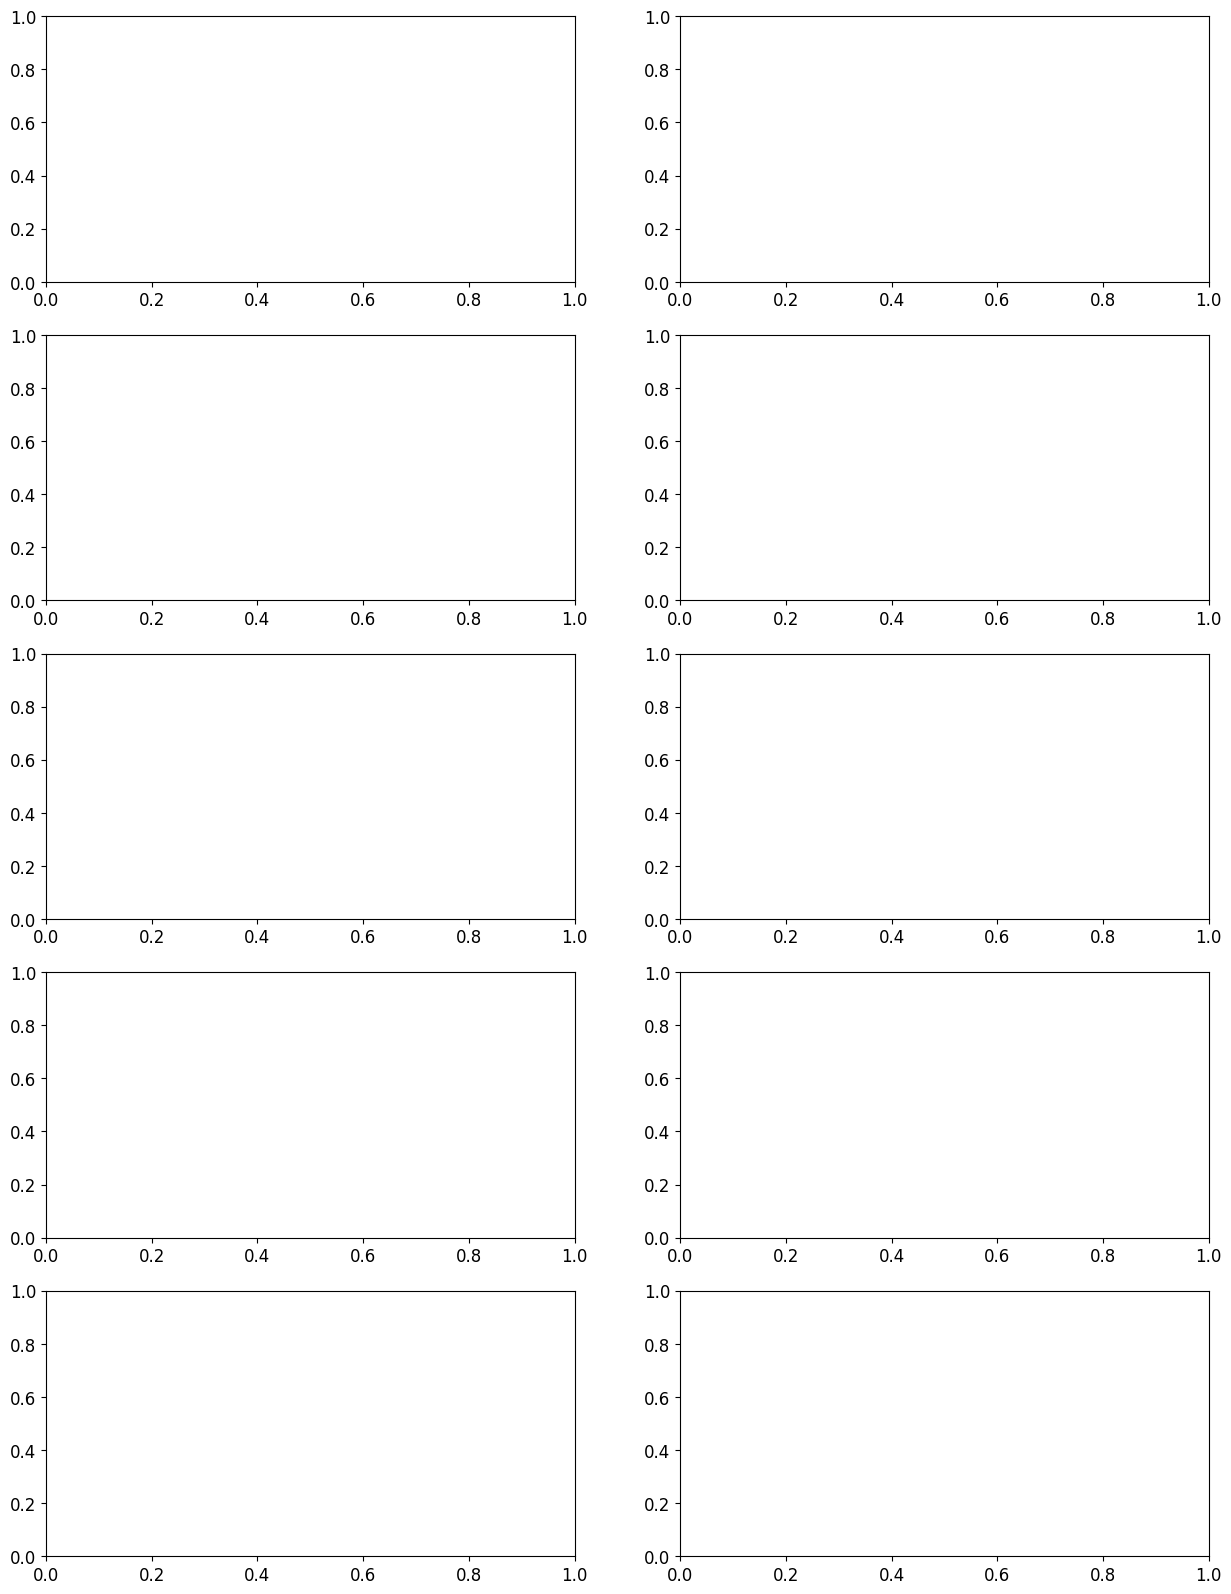

In [187]:
##################################################################################
#add your code here to visualize the feature importances generated by Zorro
top_k = 50
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()

for i, explanation in enumerate(zorro_explanations):
    path = f'zorro_explanations_{i}.png'
    explanation.visualize_feature_importance(path, top_k=top_k)
    image = plt.imread(path)
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()
##################################################################################

In [ ]:
for explanation in zorro_explanations:
    # take the selected features from the explanation
    selected_features = explanation[0][0]
    print(selected_features)
    print("Shape of tensor: ", selected_features.shape)
    
    # create a map mapping the index + 1 to the value of the feature importance
    feature_importance = {}

    for i in range(len(selected_features)):
        feature_importance[i + 1] = selected_features[i]

    print(feature_importance)

    # sort the feature importance
    feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
    print(feature_importance)

    # take the top k features
    top_k_features = dict(list(feature_importance.items())[:top_k])
    
    # plot the feature importances
    plt.figure(figsize=(10,5))
    plt.bar(range(len(top_k_features)), list(top_k_features.values()), align='center')
    plt.xticks(range(len(top_k_features)), list(top_k_features.keys()))
    plt.show()


**Calculate the fidelity for the extracted explanations**

In [200]:
##################################################################################
# for each node calculate the rdt fidelity for the feature and node mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=100, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
##################################################################################

[0.0, 0.06, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(d)Compare the importances asssigned to the features by GNNExplainer and Zorro, what do you observe from the distribution plots and what does this difference mean?**

The features obtained from GNNExplainer are correctly displayed and we can conclude from them that the nodes follow a steep curve in terms of importance, with the feature importance of the most influential features vbeing very high and there being a a long tail of features with little influence. The importances of Zorro could not be obtained, since they result in tensors of 0s after hours of computation. Thus a throrough comparison between them can not be made. Regarding the GNNExplainer we can conclude that the importances are very informative, they help in term of explainability since it can be clearly observed from the graphs which are the relevant features that the model relies on.

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(e)Compare the explanations extracted by GNNExplainer and Zorro, Which explainer is more faithful to the model and explain why?**

I would say GNNExplainer is likely to provide higher fidelity to the overall model although I cannot verify the accuracy using my results. Both Zorro and GNNExplainer try to provide insights into the model's behavior; Zorro concentrates on sparse and localized explanations while GNNExplainer aims to identify important nodes and edges in the graph. As a result, Zorro can provide more specific and interpretable insights into individual instances, but it might not capture the global behavior of the model as well as GNNExplainer.

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(f)Use number of samples [5, 10, 20, 50] in optimizing fidelity for generating Zorro's explanations. Calculate the the RDT-Fidelity for the corresponding explanations of Zorro. What do you conclude about the performance-speed tradeoff of Zorro from the results?**

In [191]:
############################################################
# add your code here to calculate RDT-Fidelity using 5 samples
# for each node calculate the rdt fidelity for the feature and node mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=5, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
############################################################

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [192]:
############################################################
# add your code here to calculate RDT-Fidelity using 10 samples
# for each node calculate the rdt fidelity for the feature and node mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=10, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
############################################################

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [193]:
############################################################
# add your code here to calculate RDT-Fidelity using 20 samples
# for each node calculate the rdt fidelity for the feature and node mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=20, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
############################################################

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [194]:
############################################################
# add your code here to calculate RDT-Fidelity using 50 samples
# for each node calculate the rdt fidelity for the feature and node mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=50, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
############################################################

[0.0, 0.06, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(g)Compare the RDT-Fidelity of the new explanations of Zorro with that of GNNExplainer. What do you conclude from the performance of explanations? **

Generating explanations using Zorro was a very slow process, taking around two hours per run. The long computation time made it very hard to debug the code since only at the end would an error become apparent as any errors or issues would only show towards the end of the computation. Fixing the errors required rerunning the entire code, resulting in a time-consuming and frustrating experience. In contrast, GNNExplainer exhibited a significantly faster performance, making it a more efficient option for generating explanations. Its quicker computation time allowed for a faster iteration loop, reducing the waiting period between runs. GNNExplainer was much faster in that regard.  If only for that reason, GNNExplainer would be my preferred method for generating explanations.

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(h.1) Define the function to calculate the sparsity of the explanations by computing the entropy of the feature masks.**

In [201]:
from scipy.stats import entropy
##################################################################################
# add your code here to define the function of calculating the sparsity of the explanations
def sparsity(explanation):
  return entropy(explanation.edge_mask)
    
##################################################################################

**(h.2)Calculate the sparsity of the feature explanation extracted by GNNExplainer**

In [202]:
##################################################################################
#add your code here 
# for each node calculate the rdt fidelity for the feature and edge mask
fidelity_scores = []

for idx in range(len(explanations)):
    score = fidelity(model=model, node_idx=ind[idx], full_feature_matrix=data.x, edge_index=data.edge_index, node_mask=None, feature_mask=None, edge_mask=explanations[i].edge_mask, samples=50, random_seed=42, device="cpu")
    fidelity_scores.append(score)

print(fidelity_scores)
##################################################################################

[0.0, 0.06, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


**(f.3)Calculate the sparsity of the feature explanation extracted by Zorro**

In [203]:
##################################################################################
#add your code here 
sparsity_list = []
for explanation in explanations:
    sparsity = sparsity(explanation)
    sparsity_list.append(sparsity)
##################################################################################

TypeError: ignored

**(f.4)Which explanation is more useful with respect to its sparsity and why?**

I would conclude stating that I consider GNNExplainer to be more useful than Zorro for me. The implementation of GNNExplainer was considerably simpler and allowed for a fast iteration loop. I struggled however to implement Zorro and would therefore favour GNNExplainer to interpret and explain models in the future. I have no doubt Zorro has good qualities and probably surpasses GNNExplainer if properly implemented, although it could not be experimentally shown here. In general, the methods were a good introduction to the study of explainability which has not been extensively touched in other subjects and which holds great relevance for the practical aplication of Graph Neural Networks.

---